# Project Notebook
This notebook contains all work on the project. Below are the research questions we wish to answer in this project.

1. How has the crops/livestock primary production developed since 1960?
2. Is there a connection between the development of livestock primary production and crop production?
3. How are the differences in production quantities between the different continents?
4. How has the development in agriculture affected emission of greenhouse gasses?

To answer this we are using 4 different datasets, all are collected from FAO-STAT (Food and Agriculture Organization of the United Nations - <http://www.fao.org/faostat/en/#data>). In this notebook we will describe and clean all of the data. 

**Note regarding our datasets from FAO:**  
- _There is limited geographical comparability due to differences between countries in methods and coverage, except for regions where countries are bound by regulations mandating harmonized methods, such as EU countries._
- _For shorter time periods, reasonably good comparability over time can be expected, as there is stability in the product definition and classification. However, as the time series are very long (from 1961) full comparability over time cannot be expected._

http://www.fao.org/faostat/en/#data/QL/metadata


## Contents
- Milestone 2 - Exploration and Data Cleaning
    - [Livestock](#livestock)
    - [Crops](#crops)
    - [Population](#population)
    - [Emission](#emission)
- [Plan for Milestone 3](#plan)
- [Milestone 3 - Research Questions](#Milestone3)  
    - [Question 1](#Q1)  
    - [Question 2](#Q2)  
    - [Question 3](#Q3)  
    - [Question 4](#Q4)  
- [Summary](#Summary)

### General Layout of Datasets
As we have collected all the datasets from the same source they are somewhat organized in the same way. There are 7 columns with metadata and for most of the values there are also flags that explain how the data was collected.


| Column name         | Explanation|
|------------------------|--------|
| Area                   |Name of country/area|
| Area Code              |Unique code for each country/area|
| Item                   |Type of product, e.g "Eggs, hen, in shell"|
| Item Code              |Unique code for each Item|
| Element                |Type data, e.g. Production, Yield, Milk Animals |
| Unit                   |The unit of the measurement of the element |
| Element Code           |Unique code based on pairs of Element and Unit|




|  Flag  | Meaning of flag        |
|--------|------------------------|
| *      | Unofficial data        |
| F      | FAO Estimate           |
| NaN    | Official data          |
| Fc     | Calculated data        |
| A      | Aggregate, may include official, semi-official, estimated or calculated data |
| M      | Data not available     | 
| Im     |FAO data based on imputation methodology |

In [1]:
# Import packages that are used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns; sns.set()
from matplotlib.font_manager import FontProperties
import warnings

---
<a id='livestock'></a>
## Livestock

The livestock dataset covers information on several livestock products globally, during the time 1961-2014. From 2014-2017 several values may be missing. The data contains all the production from both industrial production and farm production. The dataset is available at http://www.fao.org/faostat/en/#data/QL.   

Each row of the raw livestock dataset contains data on all years available, on a given metadata. There are 7 columns of metadata, which were described above, and the rest of the columns are data for each year. 

The Item also describes if a product is “indigenous” or not. If a product is not indigenous, the animal from which the product has been derived, has been imported.

In [2]:
livestock = pd.read_csv('raw_data/Production_LivestockPrimary_E_All_Data.csv', sep = ',', encoding = 'latin-1')
livestock.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2013,Y2013F,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1000 Head,4000.0,F,4400.0,...,9500.0,F,9500.0,F,9337.0,Im,9369.0,Im,10688.0,F
1,2,Afghanistan,1062,"Eggs, hen, in shell",5410,Yield,100mg/An,25000.0,Fc,25000.0,...,18947.0,Fc,19474.0,Fc,21253.0,Fc,21263.0,Fc,18713.0,Fc


### Exploration

Thorough information on all columns can be found in the notebook *livestock_data_cleaning.ipynb*.   
Here are the different elements that are found in the dataset.


|  Element             | Description            |
|----------------------|------------------------|
| Laying               | Birds raised for laying eggs        |
| Yield                | How much of the animal which is used           |
| Production           | How much is produced          |
| Producing Animals/Slaughtered    | How many animals that are being produced for meat        |
| Yield/Carcass Weight | Same as yield, but also taking account size of animal |
| Milk Animals         | How many animals used for milk production     | 
| Prod Popultn         | Population of a given item  |


### Data Cleaning

**Elements**  
As we are primarily interested in meat production in this task, we take away all elements except _Production_ and _Producing Animals/Slaughtered_. 

In [3]:
livestock_prod = livestock[(livestock['Element'] == 'Production') | (livestock['Element'] == 'Producing Animals /Slaughtered') ]

**Items**  
After removing the other elements, we remove all items that are not meat.

In [4]:
livestock_meat = livestock_prod[livestock_prod['Item'].str.contains('Meat')]
livestock_meat.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2013,Y2013F,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
8,2,Afghanistan,1137,"Meat indigenous, camel",5322,Production,Head,20000.0,F,22393.0,...,19500.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,Fc,4031.0,...,3510.0,Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Units**  
To easily compare the data, we would like to have a joint unit for all the data. We see that for each item we get two numbers, number of animals (Heads) and the weight of produced meat (tonnes). We choose to only look at produced meat, and remove the head-counts.

In [5]:
livestock_meat = livestock_meat[livestock_meat['Unit'].str.contains('tonnes')]
livestock_meat.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2013,Y2013F,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,Fc,4031.0,...,3510.0,Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,42984.0,Fc,45811.0,...,117829.0,Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Flags**  
The flags say something about the reliability of the data, but as this is the best data available we "trust" all the data. However, we do keep the flags in case we observe inconsistencies in the future.

**Reshaping**  
To have this dataset fit the same format as the others we have to reshape it, so that the yearly values are rows instead of columns. Afterwards we clean years to an int (remove Y before the year).

In [6]:
# Find the columns which are years, flags and metadata
col_years = [col for col in livestock_meat.columns if (col[0] == 'Y') and (col[-1] != 'F') ]
col_flags = [col for col in livestock_meat.columns if (col[0] == 'Y') and (col[-1] == 'F') ]
col_metadata = livestock_meat.columns[0:7]

# Do two melts, once on year and once on flag and add flags to dataframe with years
temp_years = livestock_meat.melt(id_vars = col_metadata, value_vars = col_years, var_name = 'Year', value_name = 'Value')
temp_flags = livestock_meat.melt(id_vars = col_metadata, value_vars = col_flags, var_name = 'FlagYear', value_name = 'Flag')
meat_data = temp_years.join(temp_flags['Flag'])

In [7]:
# Remove Y in years
meat_data['Year'] = meat_data['Year'].str.replace('Y', '').astype(int)

In [8]:
meat_data.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Year,Value,Flag
0,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,1961,3600.0,Fc
1,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,1961,42984.0,Fc


**Missing Data**  
Below we can see that there is some data missing in the dataset, and when we are talking about production at country-level this is not very suprising. Since 1960, a lot of states have been founded and dissolved, with the Soviet Union in 1991 as the most notable. We assume that the missing year is included somewhere else (for example Albania in Soviet Union), and remove all rows (that is years) with missing values.  

Also, we choose to remove the data after 2013 as a lot of information is missing here and we wish to have consistent data.

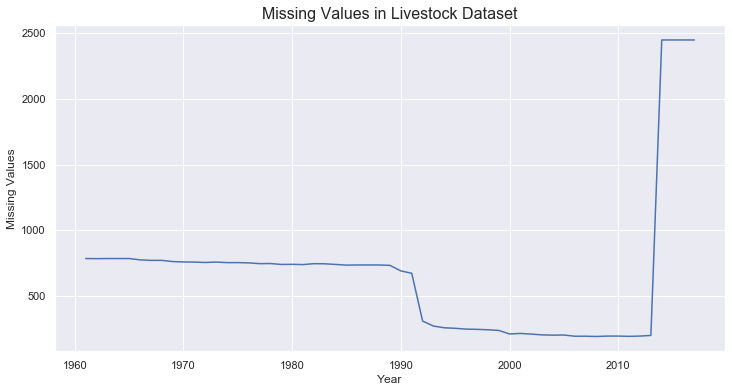

In [9]:
# Create series with missing values
missing_values = meat_data['Value'].isnull().groupby(meat_data['Year']).sum()

# Plot missing values with years on x-axis and missing values on y-axis
f = plt.figure(figsize = (12,6))
plt.plot(missing_values.index, missing_values.values)
plt.title('Missing Values in Livestock Dataset', fontsize = 16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Missing Values', fontsize=12)
plt.show()

In [10]:
# Remove all null values
meat_data = meat_data[meat_data['Value'].notnull()]

# Also remove all data after 2014 to have consistent data
meat_data = meat_data[meat_data['Year'] < 2014]

**Categorizing the Data**  
We would like to divide our dataset into areas, countries and continents for easier use in the future. Luckily, because of the way area codes are organized, this is easily done. Everything under 251 is countries, and everything above 5000 are areas. 

In [11]:
from scripts.helpers import split_fao_data
print(split_fao_data.__doc__)

meat_countries, meat_area, meat_continents = split_fao_data(meat_data)


    Function that splits data into countries, areas and continents.
    params:
        df: fao-dataframe that includes area codes.
        
    returns:
        countries: dataframe with area-code < 500
        area: dataframe with only area-code > 500
        continents: dataframe with the 6 continents
    
    


#### Summary of Livestock Dataset
After the data cleaning we have three dataframes, one for countries, one for area and one with only continents. 
We have kept the cleaning quite general in order to not miss important information, but have still ended up with a dataset that is easy to use.

### First look at the clean Livestock data
We ended up with 3 separate files for the livestock production data. One data set for the production aggregated continentally, one for country specific production and one for more specific areas within continents (e.g. Western Africa, Northern Europe). Let's take a look at how the production quantities have changed and what meats we have.

In [12]:
meat_area = pd.read_pickle('data/pickles/meat_area.pkl')
meat_cont = pd.read_pickle('data/pickles/meat_continents.pkl')
meat_country = pd.read_pickle('data/pickles/meat_countries.pkl')
meat_cont.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Year,Value,Flag
0,5100,Africa,1122,"Meat indigenous, ass",5510,Production,tonnes,1961,4150.0,A
1,5100,Africa,1084,"Meat indigenous, bird nes",5510,Production,tonnes,1961,5400.0,A
2,5100,Africa,1137,"Meat indigenous, camel",5510,Production,tonnes,1961,86018.0,A


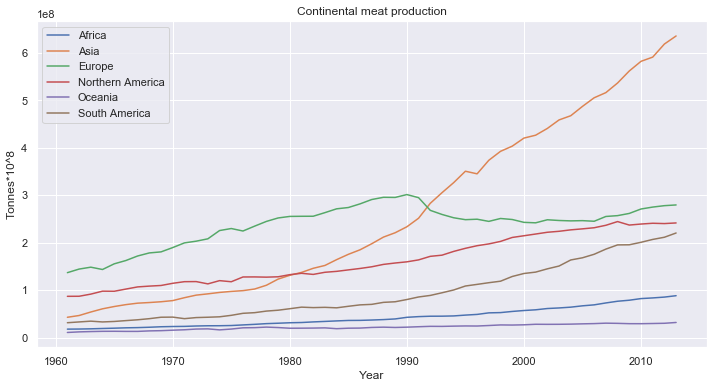

In [13]:
yearly_meat = meat_cont.groupby(['Area', 'Year']).agg({'Value':'sum'}).reset_index()

fig = plt.figure(figsize=(12, 6))
for cont in yearly_meat.Area.unique():
    y = yearly_meat[yearly_meat['Area'] == cont].Value.values
    x = yearly_meat[yearly_meat['Area'] == cont].Year.values
    
    plt.plot(x, y, label = cont)
    plt.title('Continental meat production')
    plt.ylabel('Tonnes*10^8')
    plt.xlabel('Year')
    plt.legend()

We can see that meat production has increased globally, and Asia has been the major driver in this increase. The data here is not normalized to population and Asia has experienced a major increase in population so lets take a look at production normalized to population. 

In [14]:
population = pd.read_csv('./data/csv/pop_continents.csv')

In [15]:
def plot_yearly(yearly_item, item, yearly_population, by = 'Area'):
    warnings.filterwarnings('ignore')
    fig, axs = plt.subplots(2, 2)
    
    yearly_population.sort_values(by = 'Year', inplace = True)
    groups = yearly_item[by].unique()
    world_year_population = yearly_population.groupby('Year').agg({'Value':'sum'}).reset_index()
    
    mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink']  
    fig.set_size_inches(15,12)

    plot_y = []
    for group in groups:
        y = yearly_item[yearly_item[by] == group].Value.values
        x = yearly_item[yearly_item[by] == group].Year.values
        
        axs[0,0].plot(x, y)
        
        if by == 'Area':
            y_n = yearly_item[yearly_item[by] == group].Value.values/(yearly_population[yearly_population[by] == group].Value.values*1000)
            axs[1,0].plot(x, y_n)

        plot_y.append(yearly_item[yearly_item[by] == cont].Value.values.tolist())

    axs[0,0].legend(groups)
    axs[0,0].set_title(item + ' production per continent')
    axs[0,0].set_xlabel('Year')
    axs[0,0].set_ylabel('Tonnes')
    axs[0,0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0}')) 

    axs[0,1].stackplot(x, np.vstack(plot_y), labels = groups, alpha=0.8)
    axs[0,1].legend(loc='upper left')
    axs[0,1].set_title('Total world '+ item +' production')
    axs[0,1].set_xlabel('Year')
    axs[0,1].set_ylabel('Tonnes')
    axs[0,1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0}'))
    
    if by == 'Area':
        
        axs[1,0].set_title(item + ' production per continent, normalized on continent population')
        axs[1,0].set_xlabel('Year')
        axs[1,0].set_ylabel('Tonnes')

        total_year_item = yearly_item.groupby('Year').agg({'Value':'sum'}).reset_index()

        axs[1,1].plot(total_year_item['Year'].values,
                total_year_item['Value'].values/(world_year_population['Value'].values*1000))
        axs[1,1].legend(['Total all continents'])
        axs[1,1].set_title('Total, normalized on population')
        axs[1,1].set_xlabel('Year')
        axs[1,1].set_ylabel('Tonnes')

    plt.show()

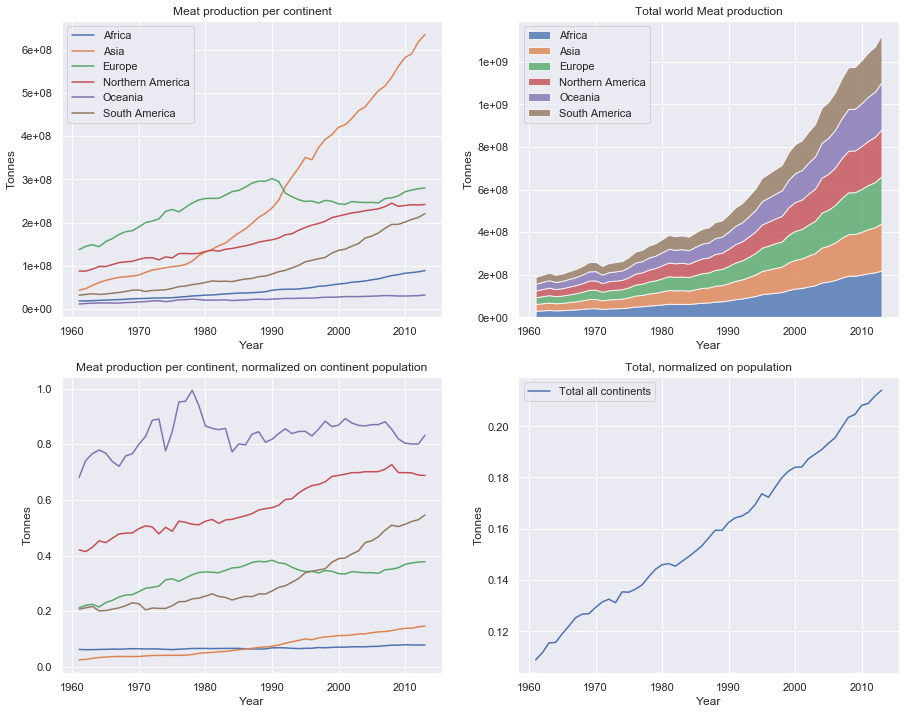

In [16]:
area_year_population = population.groupby(['Area', 'Year']).agg({'Value':'sum','Unit':'first'}).reset_index()
plot_yearly(yearly_meat, 'Meat', area_year_population, 'Area')

When we normalize by population count, we can see that Oceania is fairly volatile, perhaps a result of low population compared to the meat production. Overall we can see that when the production is normalized by population, Asia is not nearly as significant. In fact, Oceania has the largest production of meat per person. However, we can see an increase in production for all continents except Europe, where the production has not risen since the 90s. In the end, total meat production per year per person has more than doubled in the last 50 years.

Let us take a look into the production of different meats. We will choose to only focus on indigenous meat production for the time being.

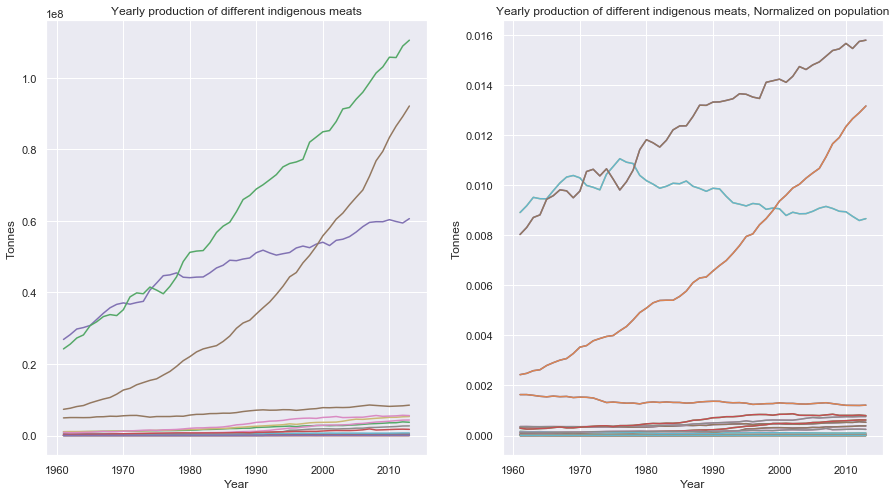

In [17]:
warnings.filterwarnings('ignore')
#Drop everythin except indigenous and drop some aggregates
meat_cont_ind = meat_cont[(meat_cont.Item.str.contains('indigenous')) &
                          (np.logical_not(meat_cont.Item.str.contains('total'))) &
                          (np.logical_not(meat_cont.Item.str.contains('poultry')))]

meat_cont_ind = meat_cont_ind.groupby(['Item', 'Year']).agg({'Value':'sum'}).reset_index()
fig = plt.figure(figsize = (15,8))

largest_groups = meat_cont_ind[meat_cont_ind['Year'] == 2013].sort_values(by = 'Value', ascending = False).head(3).Item

wy_population = area_year_population.groupby('Year').agg({'Value':'sum'}).reset_index()
groups = meat_cont_ind.Item.unique()
labels = meat_cont_ind[meat_cont_ind['Year'] == 2013].sort_values(by = 'Value', ascending = False).iloc[1:6, :].Item.values 

for group in groups:
    y = meat_cont_ind[meat_cont_ind['Item'] == group].Value.values
    x = meat_cont_ind[meat_cont_ind['Item'] == group].Year.values
        
    plt.subplot(1,2,1)
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)
        
    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different indigenous meats')
    
    
    plt.subplot(1,2,2)
    y = meat_cont_ind[meat_cont_ind['Item'] == group].Value.values/(wy_population.Value.values*1000)
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)
    
    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different indigenous meats, Normalized on population')
    plt.plot(x, y)

We clearly have 3 different meats with a significantly higher production quantity than the others. Overall the production quantities seem to have increased yearly in total, but when normalized by population count we can see that some meats have decreased in production.

In [18]:
meat_cont_ind[meat_cont_ind['Year'] == 2013].sort_values(by = 'Value', ascending = False).head()

,Item,Year,Value
688,"Meat indigenous, pig",2013,110530398.0
317,"Meat indigenous, chicken",2013,92132530.0
264,"Meat indigenous, cattle",2013,60646471.0
847,"Meat indigenous, sheep",2013,8497179.0
900,"Meat indigenous, turkey",2013,5579889.0


Our 3 most commonly produced meats are (not surprisingly) pig, chicken and cattle.

***
<a id='crops'></a>
## Crops

The crops dataset covers production of all primary crops for all countries and regions in the world and **the production is only for human consumption**. Household production is not included in the data, that is, crops that are planted for personal consumption, in for example one’s garden. The dataset is available at https://www.kaggle.com/unitednations/global-food-agriculture-statistics.  

Each row of the crops dataset contains data for a certain country/area, crop item and year. There are 7 columns of metadata, and the years in the dataset span from 1961 to 2007.

In [19]:
data = pd.read_csv('raw_data/fao_data_crops_data.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
data.head(3)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes
2,Americas +,31,Area Harvested,2005.0,Ha,49404.0,A,agave_fibres_nes


### Explanation of Columns


#### Elements
- **Area harvested** refer to the area under cultivation. Area under cultivation means the area that corresponds to the total sown area, but after the harvest it excludes ruined areas (e.g. due to natural disasters). If the same land parcel is used twice in the same year, the area of this parcel can be counted twice. 
- **Production quantity** means the harvested production. Harvested production means production including on-holding losses and wastage, quantities consumed directly on the farm and marketed quantities, indicated in units of basic product weight. *Harvest year* means the calendar year in which the harvest begins. 
- **Yield** means the harvested production per ha for the area under cultivation. 
- **Seed** quantity comprises all amounts of the commodity in question used during the reference period for reproductive purposes, such as seed or seedlings. Usually, the average seed rate in any given country does not vary greatly from year to year.
- **Gross Production, Net Production, Net per capita PIN, Grs per capita PIN, Net PIN, Gross PIN** (element codes > 140)

#### Categories
Crop statistics are recorded for 172 products, covering the following categories: Fibre Crops Primary, Cereals, Coarse Grain, Citrus Fruit, Fruit, Jute Jute-like Fibres, Oilcakes Equivalent, Oil crops Primary, Pulses, Roots and Tubers, Treenuts and Vegetables and Melons. The objective is to comprehensively cover production of all primary crops for all countries and regions in the world. 



### Data Cleaning

#### Renaming
First of all we rename the columns to fit the livestock dataset.  
This is mainly to make the first letter capital, but _Footnote_ changes to _Flag_ and _Category_ changes to _Item_.

In [20]:
new_names = {'country_or_area': 'Area', 'element_code': 'Element Code', 
             'element': 'Element', 'year': 'Year', 'unit': 'Unit', 
             'value': 'Value', 'value_footnotes': 'Flag', 'category': 'Item'}

data.rename(columns = new_names, inplace = True)
data.head(2)

,Area,Element Code,Element,Year,Unit,Value,Flag,Item
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes


#### Unnecessary rows:
The dataset is ordered according to the alphabetical order of the _Item_ and after the end of each Item, there are rows that contain the footnote-descriptions mentioned before.  
We therefore need to remove these rows since they don't contain any useful data.

In [21]:
# Removing rows that do not contain useful information
keep_col = np.logical_not(data.Area.isin(['fnSeqID', 'Fc', 'A ', 'NR', 'F ', '* ']))
crops_data = data[keep_col]

#### Keep only category totals

Since we want to analyse the general production of crops it is more interesting for us to look at the total production of the different categories instead of looking at every type of item. We will therefore only keep the totals in our dataset. The categories are stored using the following item names:
- Fibre Crops Primary = fibre_crops_primary 
- Cereals = cereals_total
- Coarse Grain = coarse_grain_total
- Citrus Fruit = citrus_fruit_total
- Fruit = fruit_excl_melons_total
- Jute Jute-like Fibres = jute_jute_like_fibres
- Oilcakes Equivalent = oilcakes_equivalent
- Oil crops Primary = oil_crops_primary
- Pulses = pulses_total
- Roots and Tubers = roots_and_tubers_total 
- Treenuts = treenuts_total 
- Vegetables and Melons = vegetables_melons_total

In [22]:
keywords = ['_total', 'primary', 'jute_jute', 'oilcakes']
items = crops_data.Item
crops_categorized = crops_data[items.str.contains('|'.join(keywords))]

print("Item categories in categorized dataset:\n", crops_categorized.Item.unique())

Item categories in categorized dataset:
 ['cereals_total' 'citrus_fruit_total' 'coarse_grain_total'
 'fibre_crops_primary' 'fruit_excl_melons_total' 'jute_jute_like_fibres'
 'oilcakes_equivalent' 'oilcrops_primary' 'pulses_total'
 'roots_and_tubers_total' 'treenuts_total' 'vegetables_melons_total']


#### Missing Data

Below we check if there is missing data in our dataset, and as we see there is none.

In [23]:
print("Missing information in categorized dataset: \n", crops_categorized.isna().sum())

Missing information in categorized dataset: 
 Area            0
Element Code    0
Element         0
Year            0
Unit            0
Value           0
Flag            0
Item            0
dtype: int64


#### Elements

**Observation:** Are the elements apart form Production Quantity really necessary?

- *Seed* is the amount of seeds that were planted, which is not relevant for the scope of this project.
- *Area Harvested* is the amount of land that was used for planting the crops in our dataset, which is not relevant for the scope of this project.
- *Yield* is the amount of crops that was given by the planted area, which is not relevant for the scope of this project.

We will therefore remove element categories: Seed, Area Harvested and Yield.

In [24]:
elements = ['Seed', 'Area Harvested', 'Yield']
crops_processed = crops_categorized[np.logical_not(crops_categorized['Element'].isin(elements))]
crops_processed.head(3)

,Area,Element Code,Element,Year,Unit,Value,Flag,Item
364540,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2007.0,1000 Int. $,896908.0,A,cereals_total
364541,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2006.0,1000 Int. $,718798.0,A,cereals_total
364542,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2005.0,1000 Int. $,841895.0,A,cereals_total


But what do the element categories with element codes > 140 include? Can we remove these?

#### Element codes > 140

In [25]:
elem_codes = ['152', '154', '434', '438', '432', '436']
study_data = crops_processed[crops_processed['Element Code'].isin(elem_codes)]
print("Number of countries in this data: ", study_data.Area.unique().shape[0])
study_data.head(5)

Number of countries in this data:  222


,Area,Element Code,Element,Year,Unit,Value,Flag,Item
364540,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2007.0,1000 Int. $,896908.0,A,cereals_total
364541,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2006.0,1000 Int. $,718798.0,A,cereals_total
364542,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2005.0,1000 Int. $,841895.0,A,cereals_total
364543,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2004.0,1000 Int. $,549037.0,A,cereals_total
364544,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2003.0,1000 Int. $,685931.0,A,cereals_total


From what we can see in the new dataset that only contain these elements, both the rows in the beginning and end have the Item cereals_total. Is this the only Item?

In [26]:
study_data.Item.unique()

array(['cereals_total'], dtype=object)

Apparently so. Does this catgory exist for the other type of elements as well? Because if it does, we should be able to remove the elements with codes 152-438 from our dataset.

In [27]:
study_data_2 = crops_processed[crops_processed.Item.str.contains('cereals_total')]
study_data_2 = study_data_2[np.logical_not(study_data_2['Element Code'].isin(elem_codes))]
print("Number of countries in this data: ", study_data_2.Area.unique().shape[0])
study_data_2['Element Code'].unique()

Number of countries in this data:  225


array(['51'], dtype=object)

We can now see that the data for the Item 'cereals_total' with element codes > 140 are subgroups of element codes < 140. We can therefore remove this data from our dataset.

In [28]:
# Drop rows with element codes > 140
drop_col = np.logical_not(crops_processed['Element Code'].isin(elem_codes))
crops_cleaned = crops_processed[drop_col]
crops_cleaned.head(3)

,Area,Element Code,Element,Year,Unit,Value,Flag,Item
364916,Afghanistan,51,Production Quantity,2007.0,tonnes,5778000.0,A,cereals_total
364917,Afghanistan,51,Production Quantity,2006.0,tonnes,4638000.0,A,cereals_total
364918,Afghanistan,51,Production Quantity,2005.0,tonnes,5425000.0,A,cereals_total


#### Area names with '+'

There are countries/areas that contain a '+' at the end of the name. What names contain this sign and what do they have in common?

In [29]:
# Examining what names contain '?'
country_series = crops_cleaned.Area
names_with_sign = country_series[country_series.str.endswith('+')]
names_with_sign.unique()

array(['Africa +', 'Americas +', 'Asia +', 'Australia and New Zealand +',
       'Caribbean +', 'Central America +', 'Central Asia +',
       'Eastern Africa +', 'Eastern Asia +', 'Eastern Europe +',
       'Europe +', 'European Union +',
       'LandLocked developing countries +', 'Least Developed Countries +',
       'Low Income Food Deficit Countries +', 'Melanesia +',
       'Micronesia +', 'Middle Africa +',
       'Net Food Importing Developing Countries +', 'Northern Africa +',
       'Northern America +', 'Northern Europe +', 'Oceania +',
       'Small Island Developing States +', 'South America +',
       'South-Eastern Asia +', 'Southern Africa +', 'Southern Asia +',
       'Southern Europe +', 'Western Africa +', 'Western Asia +',
       'Western Europe +', 'World +', 'Polynesia +'], dtype=object)

All of the country/area names that contain a '+' at the end are all areas. We can therefore divide the dataset into several groups: one with all countries, one with all continents and one with the remaining areas.

#### Categorizing the Data 

In [30]:
# Splitting crops_data into country, continent and area based sets and renaming Area column
crops_country = crops_cleaned[np.logical_not(country_series.str.endswith('+'))].rename({'Area': 'Area'}, axis=1)
crops_remain = crops_cleaned[country_series.str.endswith('+')]

# Remove last two characters from continent/area name
crops_remain.Area = crops_remain.Area.str[:-2]

continents = ['Africa', 'Northern America', 'South America', 'Asia', 'Oceania', 'Europe']
is_continent = crops_remain.Area.isin(continents)

crops_continent = crops_remain[is_continent].rename({'Area': 'Area'}, axis=1)
crops_area = crops_remain[np.logical_not(is_continent)].rename({'Area': 'Area'}, axis=1)

print('Number of unique countries:', crops_country.Area.unique().shape[0])
print('Number of unique continents:', crops_continent.Area.unique().shape[0])
print('Number of unique areas:', crops_area.Area.unique().shape[0])

Number of unique countries: 219
Number of unique continents: 6
Number of unique areas: 28


### First look at the clean crops data
Similarly to the Livestock data we ended up with 3 separate files for the crops data. One data set for the production aggregated continentally, one for country specific production and one for more specific areas within continents (e.g. Western Africa, Northern Europe). Let's take a look at how the production quantities have changed and what meats we have.

In [31]:
crops_area = pd.read_pickle('data/pickles/crops_areas.pkl')
crops_cont = pd.read_pickle('data/pickles/crops_continents.pkl')
crops_country = pd.read_pickle('data/pickles/crops_countries.pkl')

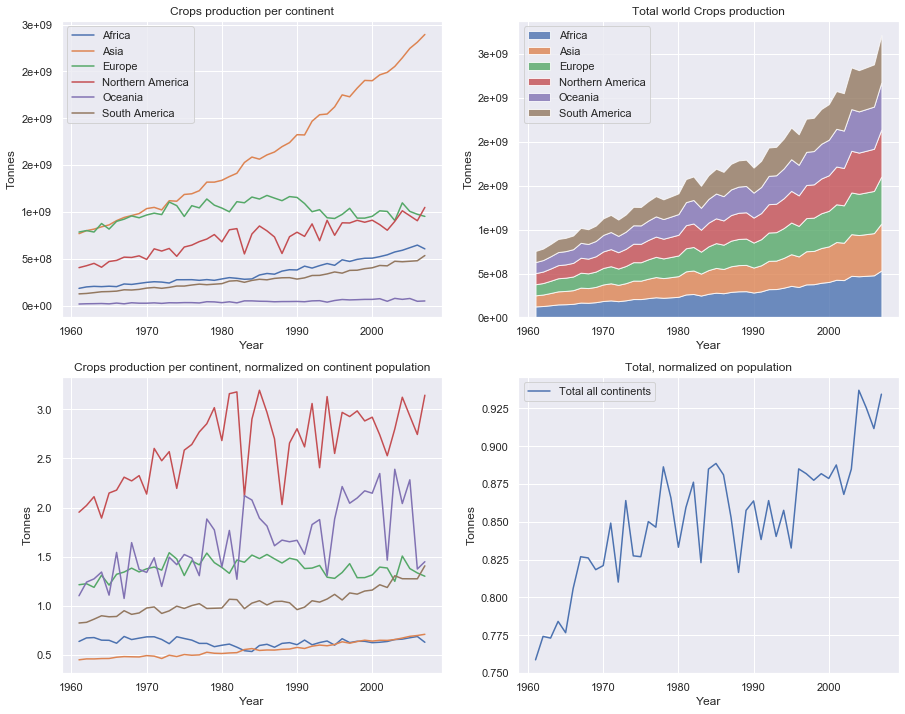

In [32]:
pop_until_08 = area_year_population[area_year_population.Year < 2008] # Crops only has data until 2007
crops_yearly = crops_cont.groupby(['Area', 'Year']).agg({'Value':'sum'}).reset_index()
plot_yearly(crops_yearly, 'Crops', pop_until_08, 'Area')

We can see a great increase in crops production in Asia and a slight increase in the other continents except Europe. The data seems to be extremely volatile for North America and Oceania.
However, overall we can see a production increase in all continents. Further investigation into reasons for the high volatility will be needed. The total crop production per person has seen a significant increase in the last 50 years.

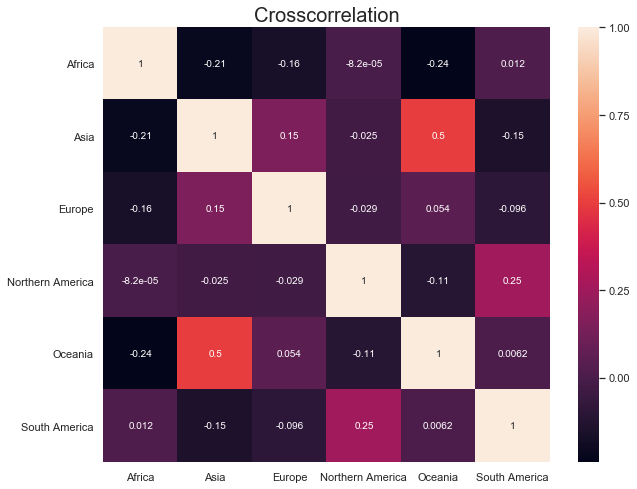

In [33]:
crops_cont_y = pd.DataFrame(crops_yearly[crops_yearly['Area'] == 'Africa'].Year)

for continent in crops_yearly['Area'].unique():
    crops_cont_y[continent] = crops_yearly[crops_yearly['Area'] == continent].Value.values

corr = np.log(crops_cont_y.iloc[:, 1:10]).diff().corr()
fig = plt.figure(figsize = (10, 8))

ax = sns.heatmap(corr, annot = True, vmax = 1)
plt.yticks(rotation= 0)
plt.xticks(rotation= 0)
plt.title('Crosscorrelation', fontsize = 20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

The change in production quantities year on year shows no correlation between different continents except between Asia and Oceania.

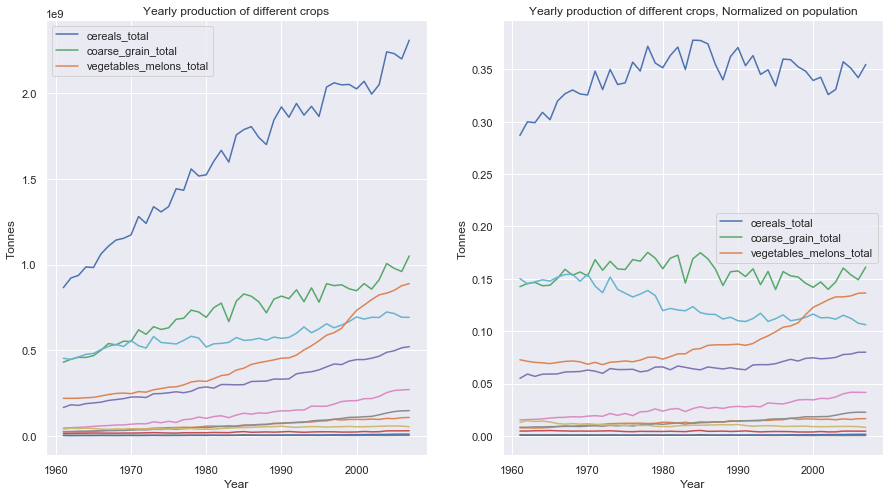

In [34]:
crops_items_yearly = crops_cont.groupby(['Item', 'Year']).agg({'Value':'sum'}).reset_index()
fig = plt.figure(figsize = (15,8))

wy_population = pop_until_08.groupby('Year').agg({'Value':'sum'}).reset_index()
groups = crops_items_yearly.Item.unique()
largest_groups = crops_items_yearly[crops_items_yearly['Year'] == 2007].sort_values(by = 'Value', ascending = False).head(3).Item

for group in groups:
    y = crops_items_yearly[crops_items_yearly['Item'] == group].Value.values
    x = crops_items_yearly[crops_items_yearly['Item'] == group].Year.values

    plt.subplot(1,2,1)
    
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)

    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different crops')
    plt.legend()

    
    plt.subplot(1,2,2)
    y = crops_items_yearly[crops_items_yearly['Item'] == group].Value.values/(wy_population.Value.values*1000)
    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different crops, Normalized on population')
    
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)

    plt.legend()

In [35]:
crops_items_yearly[crops_items_yearly['Year'] == 2007].sort_values(by = 'Value', ascending = False).head()

,Item,Year,Value
46,cereals_total,2007.0,2.310504e+09
140,coarse_grain_total,2007.0,1.050823e+09
563,vegetables_melons_total,2007.0,8.893487e+08
469,roots_and_tubers_total,2007.0,6.920577e+08
234,fruit_excl_melons_total,2007.0,5.212259e+08


The plots show that the crop group cereals is produced in significantly higher quantities than any other group. 

***
<a id='population'></a>
## Population Data

In order to interpret our data in a sensible way we also need population-data, as it of course will be a difference in food production with current population compared to 1960. The data is also collected from FAO, and looks very similar to the Livestock-dataset. The dataset can be found here http://www.fao.org/faostat/en/#data/OA.

In [36]:
population = pd.read_csv('./raw_data/fao_data_population.csv')
population.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1950,1950,1000 persons,7752.118,X,International reliable sources,"UNDESA, Population Division – World Population..."
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1951,1951,1000 persons,7840.156,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1952,1952,1000 persons,7935.997,X,International reliable sources,NaN


In [37]:
# Check unique values in dataset
for (col_name, col_data) in population.iteritems():
    print('{} has {} unique values.'.format(col_name, pd.unique(col_data).shape[0]))

Domain Code has 1 unique values.
Domain has 1 unique values.
Area Code has 273 unique values.
Area has 273 unique values.
Element Code has 1 unique values.
Element has 1 unique values.
Item Code has 1 unique values.
Item has 1 unique values.
Year Code has 69 unique values.
Year has 69 unique values.
Unit has 1 unique values.
Value has 16730 unique values.
Flag has 2 unique values.
Flag Description has 2 unique values.
Note has 2 unique values.


We see that many of the columns are irrelevant as they contain the same information in all columns. This is Domain Code, Domain, Element, Element Code, Item Code, Item, Year Code (Same as Year) and Note.  
We actually have two Flags: A and X. X is regarded most reliable(_International reliable sources_), but we will also regard A (_Aggregate, may include official, semi-official, estimated or calculated data_) as reliable. Therefore we also remove these columns.

In [38]:
drop_col = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Flag', 'Flag Description', 'Note']
population.drop(drop_col, axis = 1, inplace = True)
population.head(3)

,Area Code,Area,Year,Unit,Value
0,2,Afghanistan,1950,1000 persons,7752.118
1,2,Afghanistan,1951,1000 persons,7840.156
2,2,Afghanistan,1952,1000 persons,7935.997


As we only have data in the other datasets from 1961 to 2007/2013, we remove the extra years. 

In [39]:
population = population[(population['Year'] > 1960) & (population['Year'] < 2014)]

**Categorizing the Data**  
We would like to divide our dataset into areas, countries and continents for easier use in the future. Luckily, because of the way area codes are organized, this is easily done. Everything under 251 is countries, and everything above 5000 are areas. 

In [40]:
from scripts.helpers import split_fao_data
print(split_fao_data.__doc__)

pop_countries, pop_area, pop_continents = split_fao_data(population)


    Function that splits data into countries, areas and continents.
    params:
        df: fao-dataframe that includes area codes.
        
    returns:
        countries: dataframe with area-code < 500
        area: dataframe with only area-code > 500
        continents: dataframe with the 6 continents
    
    


#### First look at the data
To check if the data seems reasonable we plot the development in population for each continent.

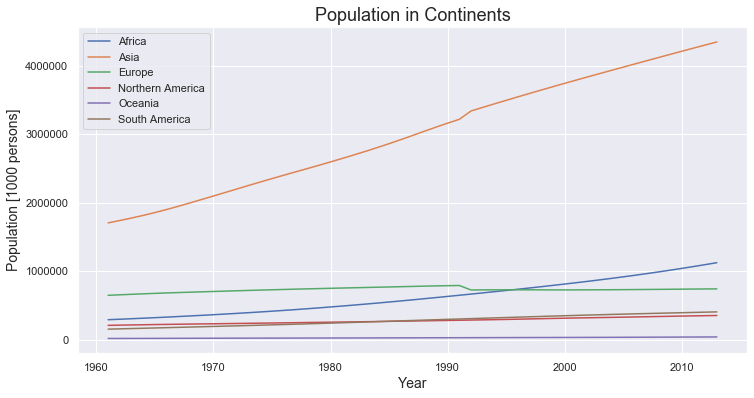

In [41]:
tmp = pop_continents.groupby(['Year', 'Area']).agg({'Value':'sum'}).reset_index()

f = plt.figure(figsize=(12, 6))

for area in tmp.Area.unique():
    y = tmp[tmp['Area'] == area].Value.values
    x = tmp[tmp['Area'] == area].Year.values
    plt.plot(x,y)
    
plt.legend(tmp.Area.unique())
plt.title('Population in Continents', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Population [1000 persons]', fontsize = 14)
plt.show()

The data looks reasonable at first glance, but we see that there is some wierd behaviour in Asia and Europe around 1990. To examine this we plot each of the continents seperately.

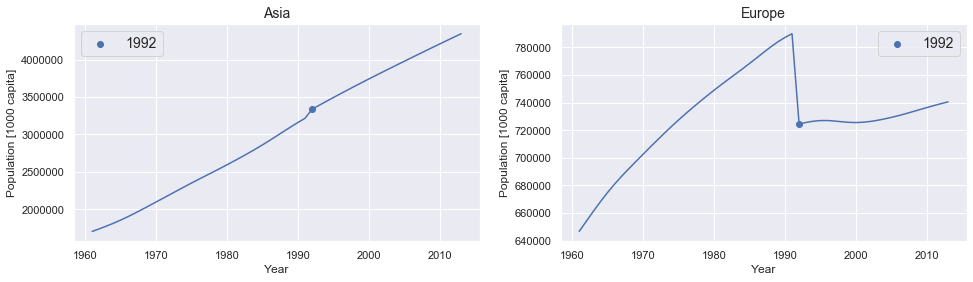

In [42]:
pop_europe_asia = pop_continents[(pop_continents['Area'] == 'Europe') | (pop_continents['Area'] == 'Asia')]
tmp = pop_europe_asia.groupby(['Year', 'Area']).agg({'Value':'sum'}).reset_index()

f = plt.figure(figsize=(16, 4))

for (ind, area) in zip(range(1,1 + tmp.Area.unique().shape[0]), tmp.Area.unique()):
    plt.subplot(1, 2, ind)
    y = tmp[tmp['Area'] == area].Value.values
    x = tmp[tmp['Area'] == area].Year.values
    plt.plot(x,y)
    plt.scatter(x = 1992, y = tmp[tmp['Year'] == 1992]['Value'].values[ind-1], label = '1992', color = 'b')
    plt.title(area, fontsize= 14)
    plt.xlabel('Year')
    plt.ylabel('Population [1000 capita]')
    plt.legend(fontsize = 14)
plt.show()

We see that we have a huge drop in the population in Europe in 1992, which coincides with the dissolution of the Soviet Union. What really happens is that some countries from the Soviet Union is now classified as Asia instead of Europe, and the relative difference in Asia is smaller than in Europe.   
There is no easy way to fix this, but luckily all other statistics are also handled in this way, so we use the dataset as it is.

***
<a id='emission'></a>
## Emissions

Since the project strive to answer questions regarding the emission that has been caused by agriculture we need data regarding this area. In this project we will be analyzing two different datasets, one will be used when we are interested in a continents total agriculture emissions while the other dataset will be used when more specific data, such as how much CO2 the pork production causes in a certain country or in the world.  


## Explanation of agriculture emissions datafiles

#### Emission data number 1
The first emissions data in our dataset covers all emissions from agriculture. That is, both the emissions from crops and livestock production. The dataset can be found here http://www.fao.org/faostat/en/#data/EM.

In [43]:
emission_data = pd.read_csv('raw_data/emission_data_continent.csv', sep = ',', encoding = 'latin-1')
emission_data.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1961,1961,gigagrams,233438.4999,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1962,1962,gigagrams,237662.8733,A,"Aggregate, may include official, semi-official...",NaN
2,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1963,1963,gigagrams,241883.7194,A,"Aggregate, may include official, semi-official...",NaN


In [44]:
from scripts.helpers import explain_df

print(explain_df.__doc__)
explain_df(emission_data)


    Prints a quick summary of the dataframe
    params:
        df: fao-dataframe with columns [Area, Year, Item, Element, Unit]
    
The data contain(s) the following: 
    area(s)    : ['Africa', 'Northern America', 'South America', 'Asia', 'Europe', 'Oceania']
    years      : 1961 - 2017
    item(s)    : ['Agriculture total']
    elements(s): ['Emissions (CO2eq)']
    unit(s)    : ['gigagrams']


As you can see from the print above we have data from all the continents, between 1961 and 2017, regarding agriculture total emissions and all data is in CO2 gigagram. 

Lets examine if there's any data missing.

In [45]:
# Is any information missing?
print("Missing information in categorized dataset:\n", emission_data.isna().sum())

Missing information in categorized dataset:
 Domain Code           0
Domain                0
Area Code             0
Area                  0
Element Code          0
Element               0
Item Code             0
Item                  0
Year Code             0
Year                  0
Unit                  0
Value                 0
Flag                  0
Flag Description      0
Note                342
dtype: int64


Note is the only column with missing values, but as far as we can tell it does not have any interesting information. So we remove it.

In [46]:
emission_data.drop(['Note'], axis = 1, inplace = True)

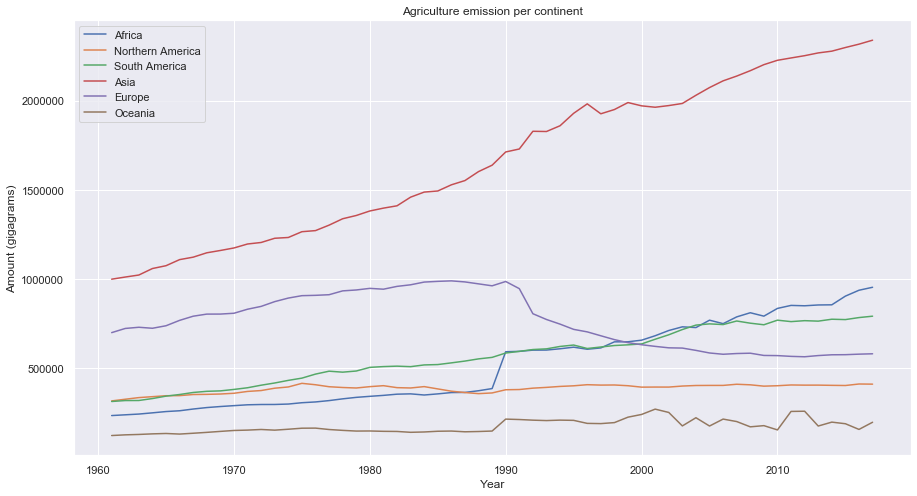

In [47]:
fig = plt.figure(figsize = (15,8))

for area in emission_data.Area.unique():
    plt.plot(emission_data[emission_data['Area'] == area].Year.values, 
             emission_data[emission_data['Area'] == area].Value.values)
    
plt.legend(emission_data.Area.unique())
plt.title('Agriculture emission per continent')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')
plt.show()

#### Plot
The data does not have any extreme outliers and without any particular knowledge in agriculture emissions, the data seems to make sense. We have a few jumps in the data that we will examine later.

#### Emission data number 2

We also have another emissions file with some categories to easier be able to determine differences in emission between crops and livestock production. This data contains emission data for each continent. The dataset can be found here http://www.fao.org/faostat/en/#data/EI.

In [48]:
categorized_emission_data = pd.read_csv('raw_data/Emission_data.csv', sep = ',', encoding = 'latin-1')
explain_df(categorized_emission_data)

The data contain(s) the following: 
    area(s)    : ['Africa', 'Northern America', 'South America', 'Asia', 'Europe', 'Oceania']
    years      : 1961 - 2016
    item(s)    : ['Cereals excluding rice', 'Rice, paddy', 'Meat, cattle', 'Milk, whole fresh cow', 'Meat, goat', 'Milk, whole fresh goat', 'Meat, buffalo', 'Milk, whole fresh buffalo', 'Meat, sheep', 'Milk, whole fresh sheep', 'Milk, whole fresh camel', 'Meat, chicken', 'Eggs, hen, in shell', 'Meat, pig']
    elements(s): ['Emissions (CO2eq)', 'Production']
    unit(s)    : ['gigagrams', 'tonnes']


This dataset contains data about the CO2 emissions coming from various areas (_items_) such as _rice_, _meat, sheep_ etc. Some of the data has information about production of each item which is not out of interest as we are interested in emissions. We will therefore remove rows with these values.

In [49]:
# Keep only emission data
categorized_emission_data = categorized_emission_data[categorized_emission_data.Element == 'Emissions (CO2eq)']

explain_df(categorized_emission_data)
# Is any information missing?
print("Missing information in categorized dataset:\n", categorized_emission_data.isna().sum())
categorized_emission_data.head(3)

The data contain(s) the following: 
    area(s)    : ['Africa', 'Northern America', 'South America', 'Asia', 'Europe', 'Oceania']
    years      : 1961 - 2016
    item(s)    : ['Cereals excluding rice', 'Rice, paddy', 'Meat, cattle', 'Milk, whole fresh cow', 'Meat, goat', 'Milk, whole fresh goat', 'Meat, buffalo', 'Milk, whole fresh buffalo', 'Meat, sheep', 'Milk, whole fresh sheep', 'Milk, whole fresh camel', 'Meat, chicken', 'Eggs, hen, in shell', 'Meat, pig']
    elements(s): ['Emissions (CO2eq)']
    unit(s)    : ['gigagrams']
Missing information in categorized dataset:
 Domain Code         0
Domain              0
Area Code           0
Area                0
Element Code        0
Element             0
Item Code           0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,EI,Emissions intensities,5100,Africa,7231,Emissions (CO2eq),1718,Cereals excluding rice,1961,1961,gigagrams,6404.6437,A,"Aggregate, may include official, semi-official..."
1,EI,Emissions intensities,5100,Africa,7231,Emissions (CO2eq),1718,Cereals excluding rice,1962,1962,gigagrams,6841.1636,A,"Aggregate, may include official, semi-official..."
2,EI,Emissions intensities,5100,Africa,7231,Emissions (CO2eq),1718,Cereals excluding rice,1963,1963,gigagrams,7246.6931,A,"Aggregate, may include official, semi-official..."


We can see that this dataset is similar to the previous one apart from the _item_ column which contains multiple values, this is what we wanted. Futhermore we have no missing values. Let's save this file.

**For now we will stick to the first dataset discussed in this notebook section since we are more interested in the total agriculture emissions.**

Let's plot the _Agriculture, total_ emissions from the dataset 1. Let's also make use of the population data so we can normalize the data on the population of a given continent or the world.

In [50]:
# Get population data
population = pd.read_csv('./data/csv/pop_continents.csv')

area_year_population = population.groupby(['Area', 'Year']).agg({'Value':'sum','Unit':'first'}).reset_index()
world_year_population = area_year_population.groupby('Year').agg({'Value':'sum'}).reset_index()

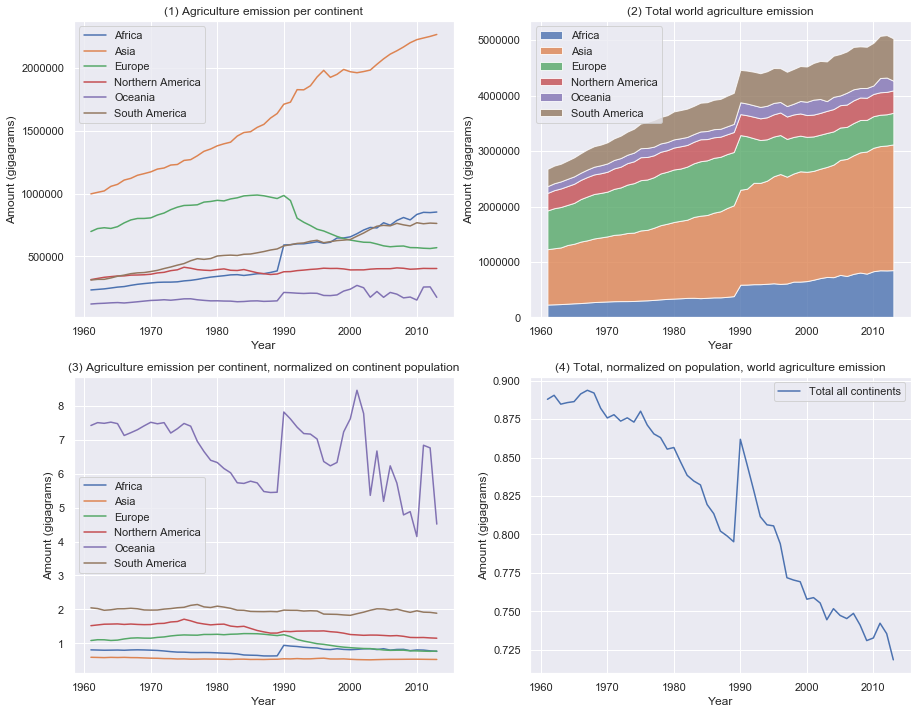

In [51]:
import warnings
warnings.filterwarnings('ignore')

area_year_emission = emission_data.groupby(['Area', 'Year']).agg({'Value':'sum','Unit':'first'}).reset_index()
area_year_emission = area_year_emission[(area_year_emission['Year'] <= 2013)]

x = area_year_emission.Year.unique()
plot_y_emi = []
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink']  
fig = plt.figure(figsize = (15,12))

areas = area_year_emission.Area.unique()

for area in areas:
    plt.subplot(2,2,3)
    plt.plot(area_year_emission[area_year_emission['Area'] == area].Year.values, 
             area_year_emission[area_year_emission['Area'] == area].Value.values/
             area_year_population[area_year_population['Area'] == area].Value.values)
   
    plt.subplot(2,2,1)
    plt.plot(area_year_emission[area_year_emission['Area'] == area].Year.values, 
             area_year_emission[area_year_emission['Area'] == area].Value.values)
    
    plot_y_emi.append(area_year_emission[area_year_emission['Area'] == area].Value.values.tolist())

plt.subplot(2,2,1)
plt.legend(areas)
plt.title('(1) Agriculture emission per continent')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

plt.subplot(2,2,3)
plt.legend(areas)
plt.title('(3) Agriculture emission per continent, normalized on continent population')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

# Global yearly emission
total_year_emission = area_year_emission.groupby('Year').agg({'Value':'sum'}).reset_index()
total_year_emission = total_year_emission[total_year_emission['Year'] <= 2013]

plt.subplot(2,2,2)
plt.stackplot(x, np.vstack(plot_y_emi), labels=area_year_emission.Area.unique(), alpha=0.8)
plt.legend(loc='upper left')
plt.title('(2) Total world agriculture emission')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

plt.subplot(2,2,4)
plt.plot(total_year_emission['Year'].values,
        total_year_emission['Value'].values/world_year_population['Value'].values)
plt.legend(['Total all continents'])
plt.title('(4) Total, normalized on population, world agriculture emission')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

plt.show()

##### Emission area plot 
There are a few questions that arise when observing the plots above:
- We can observe a big increase in emission around year 1990 which seems slightly weird.
- In the normalized continent emissions _Oceania_ has a much greater and volatile normalized emission compared to the other continents. The relatively higher normalized emission by _Oceania_ could be reasonable given that they have a lot of livestock production, however the sudden jumps in value from year to year seem off.

Let's try and find an answer to these obeservations.
The reason that the emission jumps in 1990 is most likely because of _New estimates of CO2 forest emissions and removals: 1990–2015._ Which is stated [at faostat](http://www.fao.org/faostat/en/#data/GT/metadata), where the data comes from, in point number 10.

Now, when it comes to the weird behaviour in _Oceania_'s emissions when should look at the data we have acquired regarding the crop and livestock production aswell as the population that _Oceania_ has in order to explain the weirdness. 
 

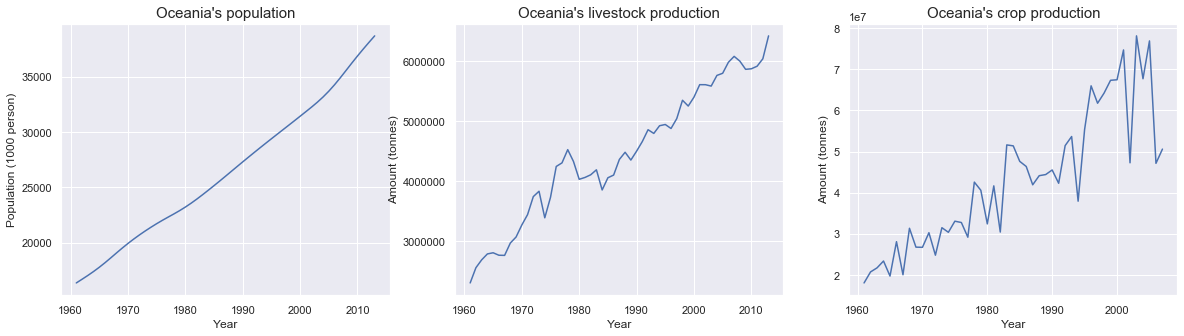

In [52]:
fig = plt.figure(figsize=(20,5))

# Oceania's population
plt.subplot(1,3,1)
plt.plot(area_year_population.Year.unique(), area_year_population[area_year_population.Area == 'Oceania'].Value.values)
plt.title('Oceania\'s population', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Population (1000 person)')

# Oceania's livestock production
plt.subplot(1,3,2)
meat_production_continents = pd.read_csv('data/csv/meat_continents.csv')
meat_production_oceania = meat_production_continents[(meat_production_continents.Area == 'Oceania') \
                                                     & (meat_production_continents.Item == 'Meat, Total')]
plt.plot(meat_production_oceania.Year.unique(), meat_production_oceania.Value.values)
plt.title('Oceania\'s livestock production', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Amount (tonnes)')

# Oceania's crops production
crop_production_continents = pd.read_pickle('data/pickles/crops_continents.pkl')
crop_production_oceania = crop_production_continents[(crop_production_continents.Area == 'Oceania')]\
                                                    .groupby('Year').agg({'Value':'sum'}).reset_index()
plt.subplot(1,3,3)
plt.plot(crop_production_oceania.Year.unique(), crop_production_oceania.Value.values)
plt.title('Oceania\'s crop production', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Amount (tonnes)')

plt.show()

We can see that there is nothing that seems to be weird with the _Oceania_'s population data, however the livestock and especially the crop production is volatile. This corresponds with the diffrences that we can observe in the agriculture emission caused by _Oceania_. Since _Oceania_ is the continent which produces the least amount of CO2 from agriculture compared to all other continents it is more likely to be volatile. For example, if the weather is bad for agriculture, it is more likely that the total amount will be affected compared to a bigger continent that is not as concentrated around a specific area.

#### Summarize

The data looks good and we are ready to move further with our analysis and use this data to answer the questions.

#### Correlation

In [53]:
# Correlations
corr = np.corrcoef(x = total_year_emission.Value.values, y = world_year_population.Value.values)[0,1]
print(f'Correlation between agriculture emission and population is {round(corr,2)}')

Correlation between agriculture emission and population is 0.99


#### Example use of second emissions dataset

In [54]:
# Emission data for sheep production for every continent and year
sheep_prod = categorized_emission_data[categorized_emission_data.Item.str.contains('sheep')]

sheep_data = sheep_prod.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'})
sheep_data['Item'] = 'Sheep'

In [55]:
sheep_data.reset_index()

,Area,Element,Year,Unit,Value,Item
0,Africa,Emissions (CO2eq),1961,gigagrams,26107.8934,Sheep
1,Africa,Emissions (CO2eq),1962,gigagrams,25742.8884,Sheep
2,Africa,Emissions (CO2eq),1963,gigagrams,25928.7068,Sheep
3,Africa,Emissions (CO2eq),1964,gigagrams,26531.4870,Sheep
4,Africa,Emissions (CO2eq),1965,gigagrams,27693.8435,Sheep
...,...,...,...,...,...,...
331,South America,Emissions (CO2eq),2012,gigagrams,13038.5218,Sheep
332,South America,Emissions (CO2eq),2013,gigagrams,13089.1212,Sheep
333,South America,Emissions (CO2eq),2014,gigagrams,12595.7720,Sheep
334,South America,Emissions (CO2eq),2015,gigagrams,12690.6373,Sheep


<a id=plan></a>
## Plan for Milestone 3

## Internal Milestones until Project Milestone 3 

In the ReadMe we have written how we will answer all the research questions, and we will therefore not go in detail of that here.  
This is to be considered an overall plan.

1 - Answer research Questions 1 & 2 (29th November)

2 - Answer research Questions 3 & 4. (6th December)
- Decide on either report or data story.

3 - Finish visuals and make a draft of report/data story (13th December)

4 - Final Deadline (20th December)
- Make sure the report/data story is consistent, and includes all the important information.
- Make sure the final notebook (extending on Milestone 2) is comprehensive and includes all mathematical calculations.
- Update readme with contributions of team members (including who works on the final presentation)

5 - Presentations (18th January)
- Finish poster for presentation
- Decide on who talks
- Prepare a 3 min presentation

<a id=Milestone3></a>

# Milestone 3
This notebook should be connected with milestone 2 at one point, but easier to work with two different notebooks.

In [56]:
from scripts.visualization import *

In [281]:
# Load data
data_path = 'data/pickles/'
meat_continent = pd.read_pickle(data_path + 'meat_continents.pkl')
crops_continent = pd.read_pickle(data_path + 'crops_continents.pkl')
pop_continent = pd.read_pickle(data_path + 'pop_continents.pkl')

We only keep the years that all of the datasets have data from.

In [282]:
# Find years in which we have data from all three datasets
starting_year = int(max(meat_continent.Year.min(), crops_continent.Year.min(), pop_continent.Year.min()))
ending_year = int(min(meat_continent.Year.max(), crops_continent.Year.max(), pop_continent.Year.max()))

# Remove all the other years
meat_continent = meat_continent[(meat_continent.Year >= starting_year) & (meat_continent.Year <= ending_year)]
crops_continent = crops_continent[(crops_continent.Year >= starting_year) & (crops_continent.Year <= ending_year)]
pop_continent = pop_continent[(pop_continent.Year >= starting_year) & (pop_continent.Year <= ending_year)]
print('In this project we will study data from {0} to {1}.'.format(starting_year, ending_year))

In this project we will study data from 1961 to 2007.


### Categorizing meat and crops categories further

Before starting the analysis, we choose to categorize the meat and crop categories further in order to make analysis easier. When having to many different categories, plots get very crowded and are harder to analyse as they get so crowded and cluttered. This is why this categorization is done.

#### Meat categorization

In [283]:
# The meat categories that already exist
meat_wanted = meat_continent[meat_continent.Item.str.contains('Meat, ')]
meat_wanted.Item.unique()

array(['Meat, ass', 'Meat, bird nes', 'Meat, buffalo', 'Meat, camel',
       'Meat, cattle', 'Meat, chicken', 'Meat, duck', 'Meat, game',
       'Meat, goat', 'Meat, goose and guinea fowl', 'Meat, horse',
       'Meat, nes', 'Meat, pig', 'Meat, rabbit', 'Meat, sheep',
       'Meat, turkey', 'Meat, Poultry', 'Meat, Total',
       'Meat, other camelids', 'Meat, other rodents', 'Meat, mule'],
      dtype=object)

We want to keep the three main meat categories separate (cattle, pig, chicken) and categorize the rest into the following:
- Equidae & Camelidae: ass, horse, camel, other camelids, mule, 
- Birds: bird nes, duck, goose & guinea fowl, turkey
- Bovidae: goat, sheep, buffalo
- Others: game, nes, rabbit + other rodents

It is chosen to put equidae & camelidae in the same category as these are such small categories.

In [276]:
# Defining the different categories
main = ['Meat, pig', 'Meat, cattle', 'Meat, chicken', 'Meat, Total']
equidae_camelidae = ['Meat, ass', 'Meat, horse', 'Meat, camel', 'Meat, other camelids', 'Meat, mule']
bovidae = ['Meat, goat', 'Meat, sheep', 'Meat, buffalo']
birds = ['Meat, bird nes', 'Meat, duck', 'Meat, goose and guinea fowl', 'Meat, turkey']
others = ['Meat, rabbit', 'Meat, other rodents', 'Meat, game', 'Meat, nes']

# Splitting the data
meat_equidae_camelidae = meat_wanted[meat_wanted.Item.isin(equidae_camelidae)]
prod_equidae_camelidae = meat_equidae_camelidae.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_equidae_camelidae['Item'] = 'Meat, equidae & camelidae'

meat_bovidae = meat_wanted[meat_wanted.Item.isin(bovidae)]
prod_bovidae = meat_bovidae.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_bovidae['Item'] = 'Meat, bovidae'

meat_birds = meat_wanted[meat_wanted.Item.isin(birds)]
prod_birds = meat_birds.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_birds['Item'] = 'Meat, bird excl chicken'

meat_others = meat_wanted[meat_wanted.Item.isin(others)]
prod_others = meat_others.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_others['Item'] = 'Meat, other'

meat_main = meat_wanted[meat_wanted.Item.isin(main)]
prod_main = meat_main.groupby(['Area','Element','Year','Unit','Item']).agg({'Value':'sum'}).reset_index()
prod_main = prod_main[['Area','Element','Year','Unit','Value','Item']]

meat_categorized = pd.concat([prod_equidae_camelidae, prod_bovidae, prod_birds, prod_others, prod_main], axis=0)
meat_categorized = meat_categorized.sort_values(by=['Year', 'Item'], ascending=True)
meat_categorized.head(3)

,Area,Element,Year,Unit,Value,Item
0,Africa,Production,1961,tonnes,3910553.0,"Meat, Total"
188,Asia,Production,1961,tonnes,9046039.0,"Meat, Total"
376,Europe,Production,1961,tonnes,30004080.0,"Meat, Total"


In [278]:
# Save dataframe to pickles
meat_categorized.to_pickle('./data/pickles/meat_categorized.pkl')
meat_cont = meat_categorized

,Area,Element,Year,Unit,Value,Item
0,Africa,Production,1961,tonnes,3910553.0,"Meat, Total"
188,Asia,Production,1961,tonnes,9046039.0,"Meat, Total"
376,Europe,Production,1961,tonnes,30004080.0,"Meat, Total"
564,Northern America,Production,1961,tonnes,17992024.0,"Meat, Total"
752,Oceania,Production,1961,tonnes,2298457.0,"Meat, Total"
...,...,...,...,...,...,...
375,Asia,Production,2007,tonnes,53224534.0,"Meat, pig"
563,Europe,Production,2007,tonnes,26398687.0,"Meat, pig"
751,Northern America,Production,2007,tonnes,11868688.0,"Meat, pig"
939,Oceania,Production,2007,tonnes,525885.0,"Meat, pig"


#### Crops categorization

In [284]:
# The crops categories that already exist
crops_continent.Item.unique()

array(['cereals_total', 'citrus_fruit_total', 'coarse_grain_total',
       'fibre_crops_primary', 'fruit_excl_melons_total',
       'jute_jute_like_fibres', 'oilcakes_equivalent', 'oilcrops_primary',
       'pulses_total', 'roots_and_tubers_total', 'treenuts_total',
       'vegetables_melons_total'], dtype=object)

We choose to categorize into the following:
- Oilcrops & oilcakes 
- Fruits excl melons: citrus fruits and fruits
- Vegetables and melons
- Roots and tubers
- Cereals
- Coarse grains
- Others: treenuts, jute & jutelike fibres, pulses, fibre crops

We choose to keep cereals and coarse grain seperate even though they are the same family as they are both big categories independently. The 'others' are all of the small crops categories.

In [285]:
# Defining the different categories
oil = ['oilcakes_equivalent', 'oilcrops_primary']
fruits = ['fruit_excl_melons_total', 'citrus_fruit_total']
veg = ['vegetables_melons_total']
roots_tubers = ['roots_and_tubers_total']
cereals = ['cereals_total']
coarse_grain = ['coarse_grain_total']
others = ['treenuts_total', 'jute_jute_like_fibres', 'pulses_total', 'fibre_crops_primary']

# Splitting the data
oil_crops = crops_continent[crops_continent.Item.isin(oil)]
prod_oil = oil_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_oil['Item'] = 'Oilcrops & oilcakes'

fruit_crops = crops_continent[crops_continent.Item.isin(fruits)]
prod_fruit = fruit_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_fruit['Item'] = 'Fruits excl melons'

veg_crops = crops_continent[crops_continent.Item.isin(veg)]
prod_veg = veg_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_veg['Item'] = 'Vegetables & melons'

roots_tubers_crops = crops_continent[crops_continent.Item.isin(roots_tubers)]
prod_roots_tubers = roots_tubers_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_roots_tubers['Item'] = 'Roots & tubers'

cereals_crops = crops_continent[crops_continent.Item.isin(cereals)]
prod_cereals = cereals_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_cereals['Item'] = 'Cereals'

coarse_grain_crops = crops_continent[crops_continent.Item.isin(coarse_grain)]
prod_coarse_grain = coarse_grain_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_coarse_grain['Item'] = 'Coarse grain'

coarse_grain_crops = crops_continent[crops_continent.Item.isin(coarse_grain)]
prod_coarse_grain = coarse_grain_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_coarse_grain['Item'] = 'Coarse grain'

other_crops = crops_continent[crops_continent.Item.isin(others)]
prod_other = other_crops.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
prod_other['Item'] = 'Other crops'

total_crops = crops_continent.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'}).reset_index()
total_crops['Item'] = 'Crops, total'

crops_categorized = pd.concat([prod_oil, prod_fruit, prod_veg, prod_roots_tubers, prod_cereals, prod_coarse_grain, prod_other, total_crops], axis=0)
crops_categorized = crops_categorized.sort_values(by=['Year', 'Item'], ascending=True)
crops_categorized.head(3)

,Area,Element,Year,Unit,Value,Item
0,Africa,Production Quantity,1961.0,tonnes,46276719.0,Cereals
47,Asia,Production Quantity,1961.0,tonnes,329540554.0,Cereals
94,Europe,Production Quantity,1961.0,tonnes,263708561.0,Cereals


In [286]:
# Save dataframe to pickles
crops_categorized.to_pickle('./data/pickles/crops_categorized.pkl')
crops_cont = crops_categorized

<a id=Q1></a>
## Question 1 - How has the crops and livestock production changed since the 1960s?
To get a general picture of how production has changed we start by looking at everything at a world-level.

This question will serve as an intro to the whole project and look at the big trends in the world, with focus on products more than areas. We will mainly study total development of production (without normalizing for population), as this is how the production actually has developed and how the scale has changed during the 50 years.
We will follow these steps:

- Get an overview of development by analyzing at world-level.
- Look if any special products have increased/decreased in popularity.
- Find statistical indicators showing the differences now and in 1960.
- Look for certain countries and areas that stand out.

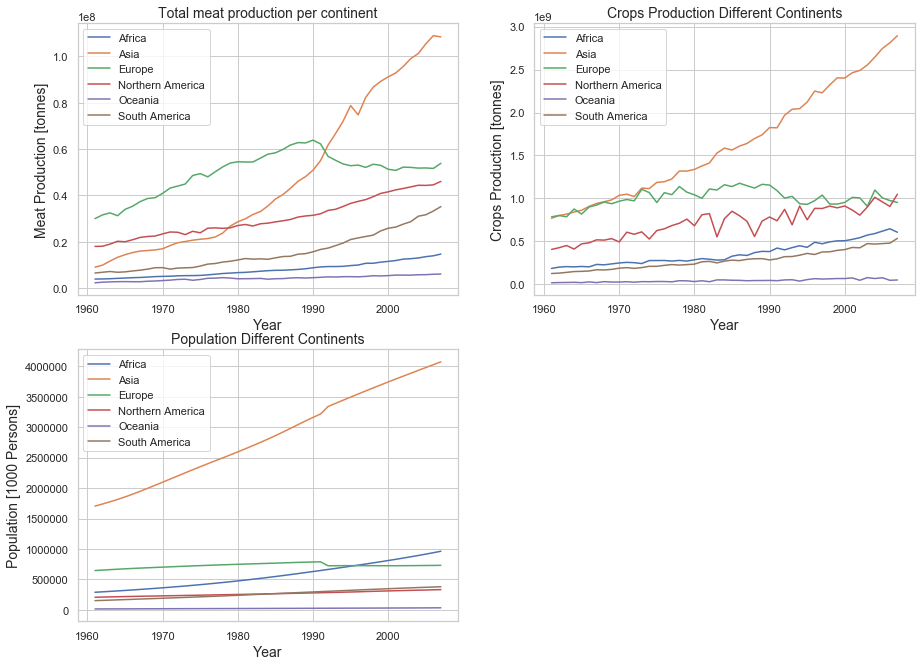

In [59]:
# Plot of how meat production, crops production and population have developed since 1961

fig = plt.figure(figsize = (15, 11))
meat_total = meat_cont[meat_cont.Item == 'Meat, Total']
meat_no_total = meat_cont[np.logical_not(meat_cont.Item == 'Meat, Total')]
crops_total = crops_cont[crops_cont.Item == 'Crops, total']
crops_no_total = crops_cont[np.logical_not(crops_cont.Item == 'Crops, total')]

ax1 = plt.subplot(2,2,1)
plot_compare_areas(meat_total, 
                   y = 'Value', y_label = 'Meat Production [tonnes]',
                   title='Total meat production per continent',
                   subplot = True, ax = ax1)

ax2 = plt.subplot(2,2,2)
plot_compare_areas(crops_total, 
                    y = 'Value', y_label = 'Crops Production [tonnes]',
                    title='Crops Production Different Continents',
                    subplot = True, ax = ax2)

ax3 = plt.subplot(2,2,3)
plot_compare_areas(pop_cont, 
                    y = 'Value', y_label = 'Population [1000 Persons]',
                    title='Population Different Continents',
                    subplot = True, ax = ax3)

We saw these plots earlier already in milestone 2. However, they nicely show how crops production, meat production and the population has risen globally since 1961. We can also see that the way that the production has developped follows a general pattern, that is, the population growth in each respective continent. This makes sense as an increased population will require more food production in order to be able to feed all habitants. 

In the population growth plot, there is a non-linear change in the population growth for both Europe and Asia in 1991. This is due to the fall of the Soviet Union in 1991 which resulted in new continent borders for Europe and Asia.

The drop in the meat production in Asia in 1997 is probably due to the asian financial crisis. The only meat production category that also drops this year is pig and when doing som research on Google, some results show that the asian financial crisis in 1997 affected the pig production. ([article 1](https://books.google.ch/books?id=DQUFd2UBUAwC&pg=PA5&lpg=PA5&dq=1995+asia+pig+production&source=bl&ots=8U_-qWYyqa&sig=ACfU3U3nubnDJojZckPCrny5KO-q0PjHuA&hl=en&sa=X&ved=2ahUKEwizv4Pr9rzmAhURsXEKHfYaCLUQ6AEwAXoECAoQAQ#v=onepage&q=asian%20financial%20crisis&f=false), [article 2](https://books.google.ch/books?id=eXtZwpHL5AcC&pg=RA1-PA2&lpg=RA1-PA2&dq=asian+financial+crisis+pig+production+1997&source=bl&ots=8Q74PJcET8&sig=ACfU3U249goE42MgSw9ODL2r8eNHVBcQQg&hl=en&sa=X&ved=2ahUKEwjE7MqG-rzmAhXj0aYKHY6fA20Q6AEwFnoECAsQAQ#v=onepage&q=asian%20financial%20crisis%20pig%20production%201997&f=false))

The crops production is in general quite volatile which is not surprising as crops production is very weather dependent which can lead to good and bad harvest years.

### Percentage increase of crops & meat production and population

Now we look at exactly how much the crops & meat production and population has increased since 1961 for each continent and for the world. 

In [60]:
# Adding world data to dataframes that are being studied

meat_total_world = meat_total.groupby('Year').agg({'Area':'first', 'Element':'first', 
                                                   'Value':'sum', 'Unit':'first', 'Item':'first'}).reset_index()
meat_total_world.Area = 'World'
meat_total_all = pd.concat([meat_total_world, meat_total], axis=0)

crops_total_world = crops_total.groupby('Year').agg({'Area':'first', 'Element':'first', 
                                                     'Value':'sum', 'Unit':'first', 'Item':'first'}).reset_index()
crops_total_world.Area = 'World'
crops_total_all = pd.concat([crops_total_world, crops_total], axis=0)

pop_total_world = pop_cont.groupby('Year').agg({'Area Code':'first', 'Area':'first', 'Unit':'first', 
                                                'Value':'sum'}).reset_index()
pop_total_world.Area = 'World'
pop_total_all = pd.concat([pop_total_world, pop_cont], axis=0)

In [61]:
# Comparing areawise total production of meat in raw numbers
meat_start_year = meat_total_all[meat_total_all['Year'] == starting_year]
meat_end_year = meat_total_all[meat_total_all['Year'] == ending_year]

comparison_m = pd.DataFrame({'Area':meat_start_year.Area.unique(), 
                          '1961 total [tonnes]':meat_start_year.Value.values, 
                          '2007 total [tonnes]':meat_end_year.Value.values})
comparison_m['% Increase'] = round(comparison_m['2007 total [tonnes]']/comparison_m['1961 total [tonnes]']*100-100,2)
comparison_m = comparison_m.sort_values(by = 'Area')
print("Total meat production comparison for years 1961 and 2007 and each continent:\n", comparison_m)

# Comparing areawise total production of crops in raw numbers
crops_start_year = crops_total_all[crops_total_all['Year'] == starting_year]
crops_end_year = crops_total_all[crops_total_all['Year'] == ending_year]

comparison_c = pd.DataFrame({'Area':crops_start_year.Area.unique(), 
                          '1961 total [tonnes]':crops_start_year.Value.values, 
                          '2007 total [tonnes]':crops_end_year.Value.values})
comparison_c['% Increase'] = round(comparison_c['2007 total [tonnes]']/comparison_c['1961 total [tonnes]']*100-100,2)
comparison_c = comparison_c.sort_values(by = 'Area')
print("\nTotal crops production comparison for years 1961 and 2007 and each continent:\n", comparison_c)

# Comparing areawise total population growth in raw numbers
population_start_year = pop_total_all[pop_total_all['Year'] == starting_year]
population_end_year = pop_total_all[pop_total_all['Year'] == ending_year]

comparison_p = pd.DataFrame({'Area':population_start_year.Area.unique(), 
                          '1961 total [tonnes]':population_start_year.Value.values, 
                          '2007 total [tonnes]':population_end_year.Value.values})
comparison_p['% Increase'] = round(comparison_p['2007 total [tonnes]']/comparison_p['1961 total [tonnes]']*100-100,2)
comparison_p = comparison_p.sort_values(by = 'Area')
print("\nTotal population comparison for years 1961 and 2007 and each continent:\n", comparison_p)

Total meat production comparison for years 1961 and 2007 and each continent:
                Area  1961 total [tonnes]  2007 total [tonnes]  % Increase
1            Africa            3910553.0           14699140.0      275.88
2              Asia            9046039.0          108466131.0     1099.05
3            Europe           30004080.0           53861619.0       79.51
4  Northern America           17992024.0           46055112.0      155.98
5           Oceania            2298457.0            6083622.0      164.68
6     South America            6517115.0           35185524.0      439.89
0             World           69768268.0          264351148.0      278.90

Total crops production comparison for years 1961 and 2007 and each continent:
                Area  1961 total [tonnes]  2007 total [tonnes]  % Increase
1            Africa         1.851338e+08         6.063324e+08      227.51
2              Asia         7.687699e+08         2.894075e+09      276.46
3            Europe         

As could be seen in the plots in the previous section, all continents have seen an increase in crops and meat production. In fact, the production in all continents has has more than doubled except for Europe. Overall, there has been an immense increase in production of crops and the World production has almost tripled fro crops. Incredibly, meat production has risen by over 1000% in Asia. Overall, the global meat production has almost quadrupled. 

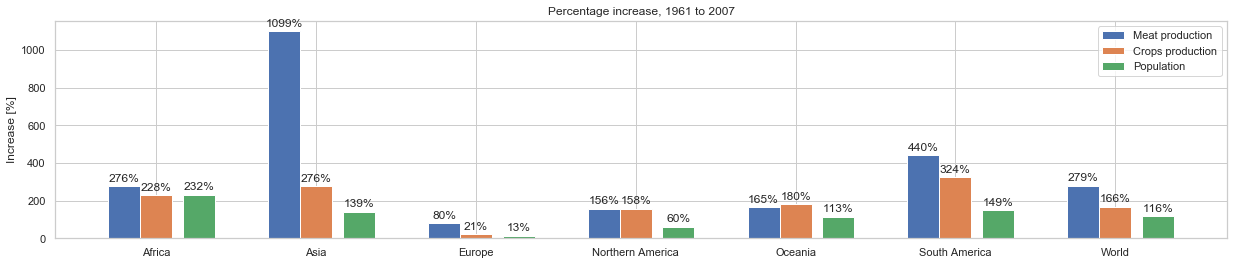

In [62]:
# Results from previous cell visualized
labels = comparison_p.Area.sort_values().unique()

x = np.arange(len(labels))+10  # the label locations
width = 0.2 # the width of the bars

fig, ax = plt.subplots(figsize=(21,4))
rects1 = ax.bar(x - width, round(comparison_m['% Increase']), width, label='Meat production')
rects2 = ax.bar(x, round(comparison_c['% Increase']), width, label='Crops production')
rects3 = ax.bar(x + width + width/3, round(comparison_p['% Increase']), width, label='Population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Increase [%]')
ax.set_title('Percentage increase, 1961 to 2007')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(str(height)+'%'),
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    xytext = (0, 3),  # 3 points vertical offset
                    textcoords = "offset points",
                    ha = 'center', va = 'bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.savefig('plots/Increase-meat-crop-pop.png', bbox_inches = 'tight')

Here we can see that the increase in food production (since 1961) is more than the increase in population. This means that we are producing more food per person today compared to 1961.

All continents but North America and Oceania have a larger increase in meat producation than both crops production and population growth. This is probably due to the fact that North America and Oceania already had a very large meat production per persoon in 1961 as was seen in Milestone 2. As mentioned before, meat production in Asia has increased more than ten-fold, which is not surprising as the majority of Asians in 1961 were living in extreme poverty, whereas in 2007, the majority of Asians were living out of extreme poverty (source Gapminder).

### Comparison of the yearly increases of different meat and crop production

Text(0.5, 1.0, 'Mean yearly (%) increase of different crops')

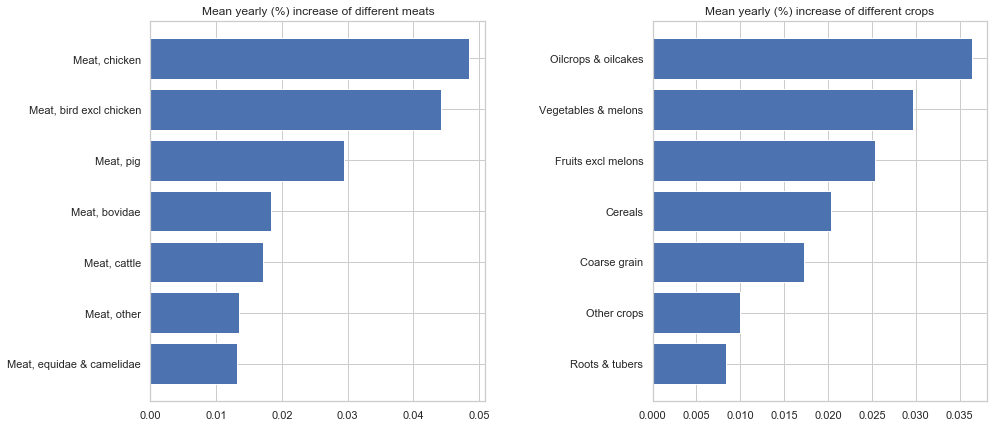

In [63]:
fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(15,7)
fig.subplots_adjust(wspace = 0.5)

# Create dataframe with mean yearly change in production of different meat products
mean_mproduct_growth = {}
for item in meat_no_total.Item.unique():
    mean_mproduct_growth.update({item: (meat_no_total[meat_no_total.Item == item].groupby('Year').sum().diff() 
                                        / meat_no_total[meat_no_total.Item == item].groupby('Year').sum()).Value.mean()})

mean_mproduct_growth = pd.DataFrame(mean_mproduct_growth.values(), mean_mproduct_growth.keys(), columns = ['Mean growth'])
mean_mproduct_growth.sort_values(by='Mean growth', inplace =True)

# Create dataframe with mean yearly change in production of different crops products
mean_cproduct_growth = {}
for item in crops_no_total.Item.unique():
    mean_cproduct_growth.update({item : (crops_no_total[crops_no_total.Item == item].groupby(['Year']).sum().diff()
                                        / crops_no_total[crops_no_total.Item == item].groupby(['Year']).sum()).Value.mean()})

mean_cproduct_growth = pd.DataFrame(mean_cproduct_growth.values(), mean_cproduct_growth.keys(), columns = ['Mean growth'])
mean_cproduct_growth.sort_values(by='Mean growth', inplace =True)

# Plot results
ax[0].barh(mean_mproduct_growth.index, mean_mproduct_growth['Mean growth'])
ax[0].set_title("Mean yearly (%) increase of different meats")

ax[1].barh(mean_cproduct_growth.index, mean_cproduct_growth['Mean growth'])
ax[1].set_title("Mean yearly (%) increase of different crops")

In the above plot we can see that different products have in fact experienced similar yearly increases in their production. Different kinds of poultry have experienced the largest year on year growth with chicken at nearly 5%. Poultry is very popular in Asia, thus it is no surprise that these have experienced such large growth. Interestingly the largest increase for crops have been oilcrops & oilcakes. Overall the year on year growth has been smaller for most crops compared to meat products. Cereals and coarse grain which are the two biggest crops categories have experienced moderate growth. 

### Comparison of the different production quantities for the different product categories and their variances

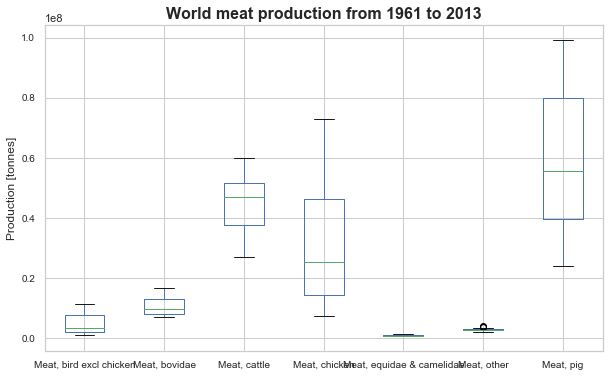

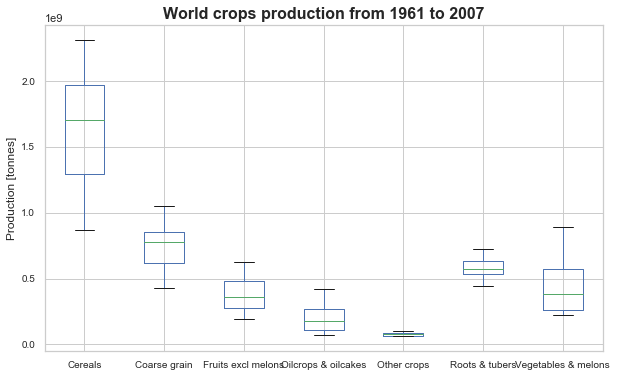

In [64]:
# Creat new dataframe for meat production where indexes are years and columns are the different meat categories
world_m = meat_no_total.groupby(['Year', 'Item']).agg({'Value':'sum'}).reset_index().sort_values(by=['Year', 'Item'], 
                                                                                                 ascending=True)
meat_world = pd.DataFrame(columns=meat_no_total.Item.sort_values().unique(), 
             index=world_m.Year.unique(),
             data=world_m.Value.values.reshape(len(world_m.Year.unique()),len(meat_no_total.Item.unique())))

# Plot box plot of the different meat categories and how their production quantities have been over the years
ax = meat_world.plot(kind='box', figsize=(10,6))
ax.set_title('World meat production from 1961 to 2013', fontsize=16, fontweight='bold')
ax.set_ylabel('Production [tonnes]', fontsize=12)
ax.tick_params(labelsize=10)

# Creat new dataframe for crops production where indexes are years and columns are the different crops categories
world_c = crops_no_total.groupby(['Year', 'Item']).agg({'Value':'sum'}).reset_index().sort_values(by=['Year', 'Item'], 
                                                                                                  ascending=True)
crops_world = pd.DataFrame(columns=crops_no_total.Item.sort_values().unique(), 
             index=world_c.Year.unique(),
             data=world_c.Value.values.reshape(len(world_c.Year.unique()),len(meat_no_total.Item.unique())))

# Plot box plot of the different crops categories and how their production quantities have been over the years
ax = crops_world.plot(kind='box', figsize=(10,6))
ax.set_title('World crops production from 1961 to 2007', fontsize=16, fontweight='bold')
ax.set_ylabel('Production [tonnes]', fontsize=12)
ax.tick_params(labelsize=10)

When it comes to meat production, we are producing mostly pig, chicken and cattle and pig production is the biggest. 
When it comes to crops production, we are producing mostly cereals which isn't surprising as rice and wheat are included in the cereals category. The production of 'meat, other', 'meat, equidae & camildae' and 'other crops' has been quite consistent since 1961 as their variance is very low compared to the others.

Let's visualize this in a line plot to make sure that the observations are correct.

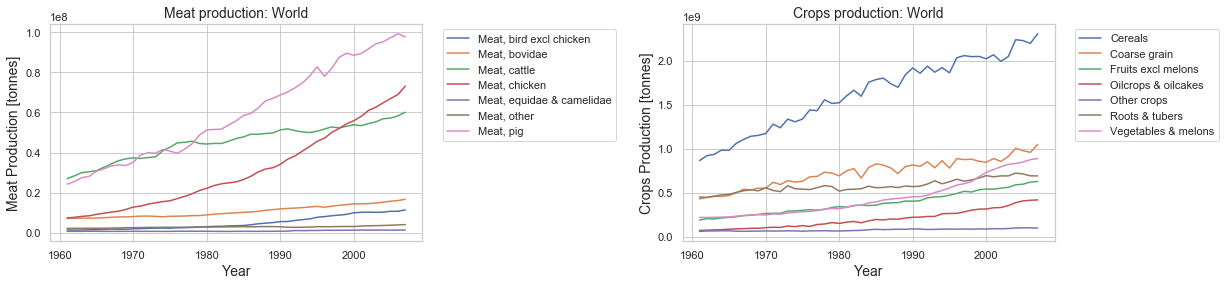

In [65]:
plt.figure(figsize=(18,4)).subplots_adjust(wspace=0.7)
plot_compare_areas(world_m, grouping = 'Item', y = 'Value', y_label = 'Meat Production [tonnes]', 
                   title = 'Meat production: World', subplot = True, ax = plt.subplot(1, 2, 1), outside = True)
plot_compare_areas(world_c, grouping = 'Item', y = 'Value', y_label = 'Crops Production [tonnes]', 
                   title = 'Crops production: World', subplot = True, ax = plt.subplot(1, 2, 2), outside = True)

plt.savefig('plots/Food-development.png', bbox_inches = 'tight')

What was observed in the box plot can also be observed in these plots. Pig is the biggest meat category and cereals is the biggest crops category. The production of 'meat, other', 'meat, equidae & camildae' and 'other crops' has been quite consistent since 1961.

### Food production development in each continent

Lets study the food production more in detail. What does the production look like for each continent?

#### Meat production

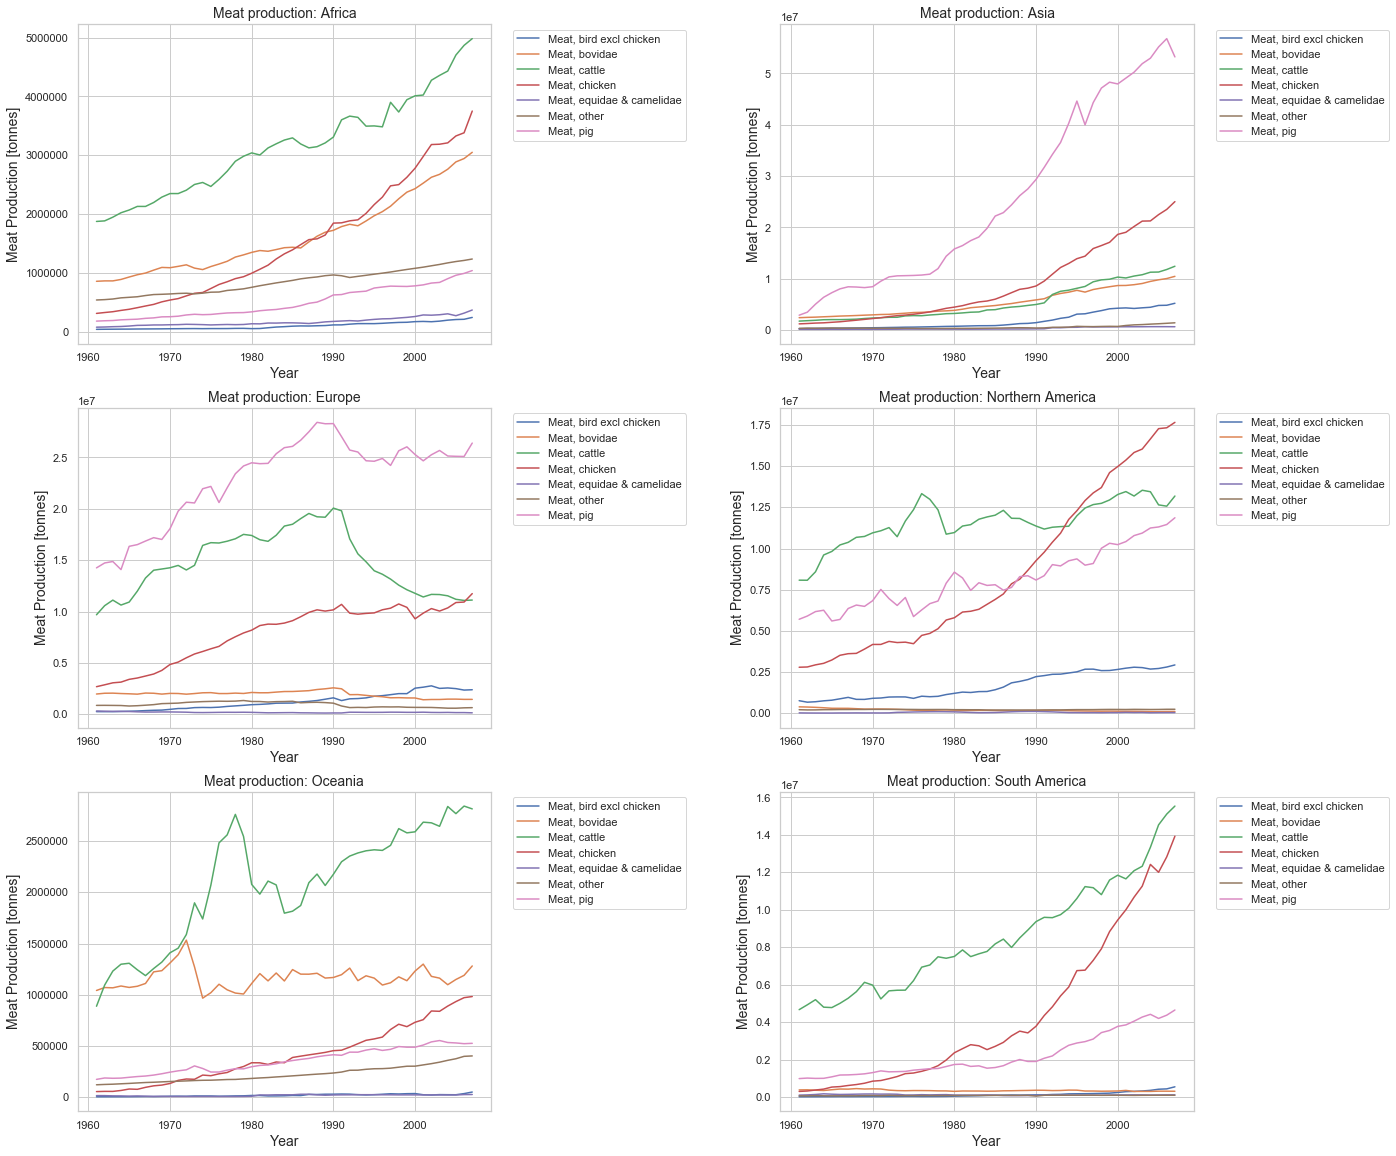

In [66]:
plt.figure(figsize=(20,20)).subplots_adjust(wspace=0.7)
i = 0

for area in meat_cont.Area.unique():
    i+=1
    plot_compare_areas(meat_no_total[meat_no_total['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Meat Production [tonnes]', title = 'Meat production: '+area,
                    subplot = True, ax = plt.subplot(3, 2, i), outside = True)

**Continents that stand out:**
- Africa and Oceania are the only continents that have had a big increase in the meat category 'others'.
- In 2013 the three biggest meat categories are cattle, pig and chicken in all continents except Africa and Ocenia that have bovidae, cattle and chicken in top three. 

We wish to check what type of bovidae and other meats that Oceania and Africa produce a lot of.

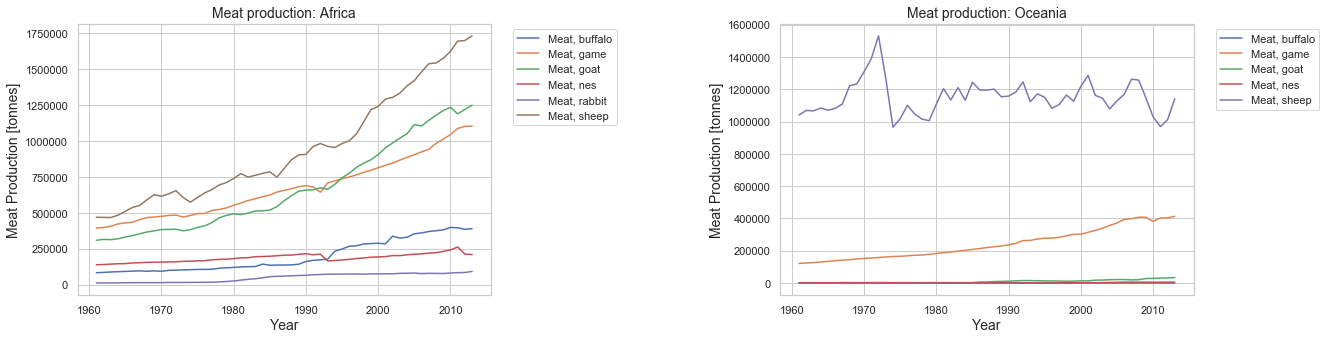

In [67]:
meat_uncategorized = pd.read_pickle(data_path + 'meat_continents.pkl')

interesting = ['Meat, goat', 'Meat, sheep', 'Meat, buffalo', 'Meat, rabbit', 'Meat, other rodents', 'Meat, game', 'Meat, nes']
meat_interesting = meat_uncategorized[meat_uncategorized.Item.isin(interesting)]
meat_interesting = meat_interesting[meat_interesting.Area.isin(['Oceania', 'Africa'])]

plt.figure(figsize=(20,5)).subplots_adjust(wspace=0.7)
i = 0

for area in meat_interesting.Area.unique():
    i+=1
    plot_compare_areas(meat_interesting[meat_interesting['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Meat Production [tonnes]', title = 'Meat production: '+area,
                    subplot = True, ax = plt.subplot(1, 2, i), outside = True)

**Observations**

Africa : It seems as though the big production of buffalo and goat in Africa is what makes bovidae such a big production category. Game is also a big category in Africa and this is probably what gives the big increase of the 'others' category.

Oceania : It seems as though the big production sheep in Oceania is what makes bovidae such a big production category. Game is also a relatively big category in Oceania and this is probably what gives the big increase of the 'others' category.

#### Crops production

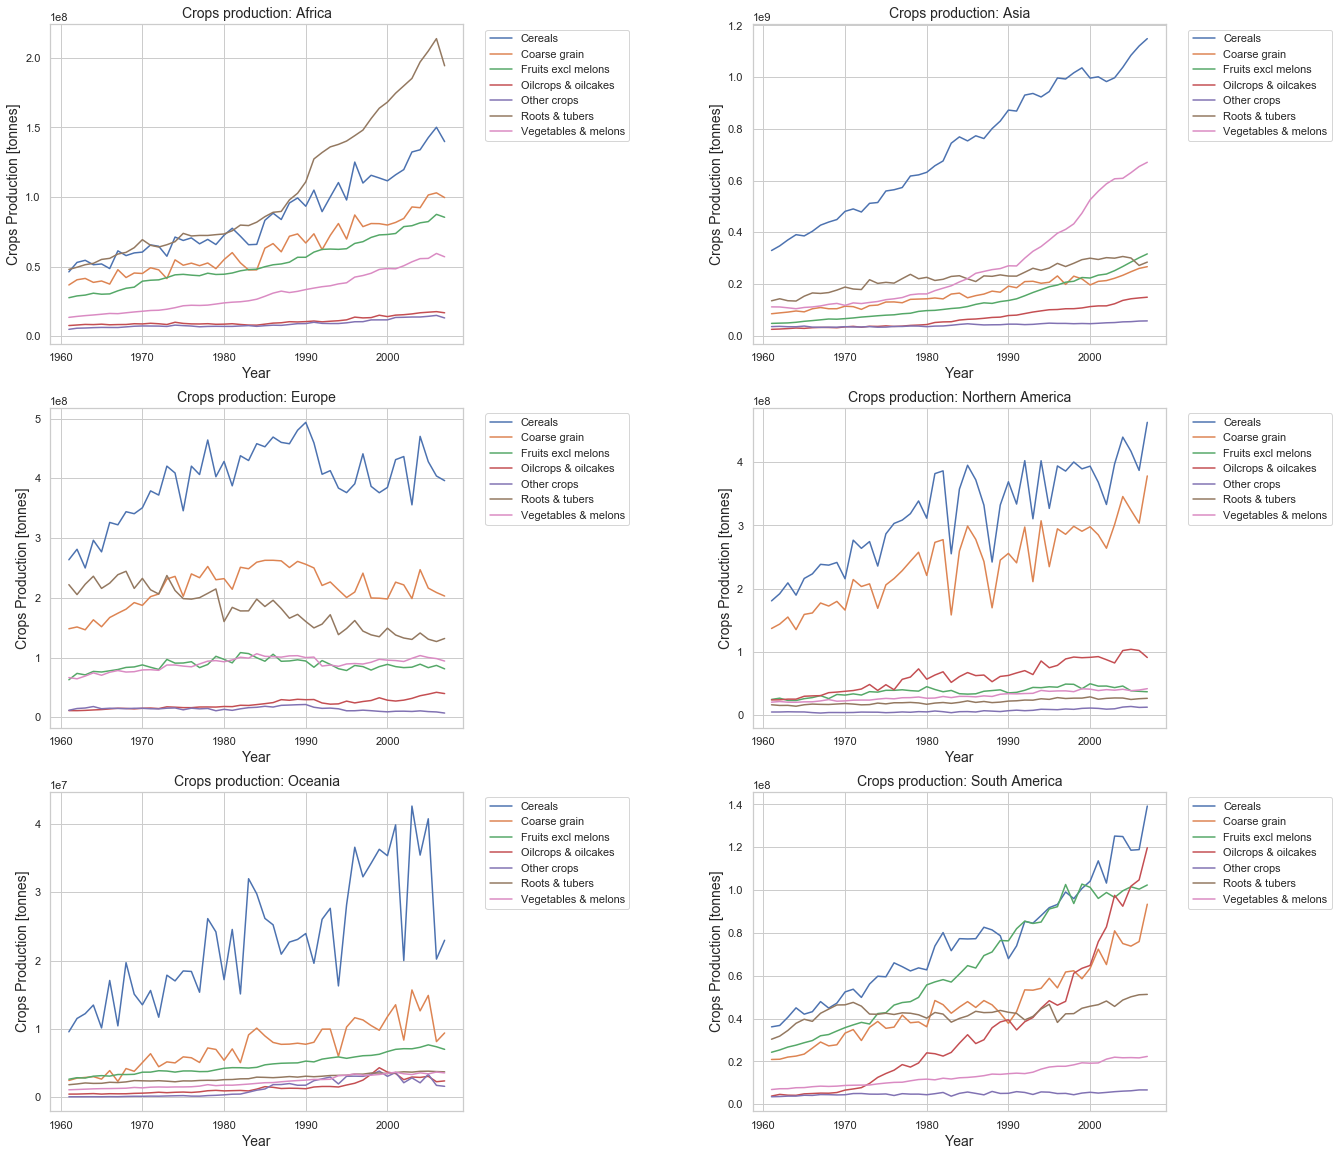

In [68]:
fig = plt.figure(figsize = (20, 20)).subplots_adjust(wspace=0.7)
i = 0

for area in crops_cont.Area.unique():
    i+=1
    plot_compare_areas(crops_no_total[crops_no_total['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Crops Production [tonnes]', title = 'Crops production: '+area,
                    subplot = True, ax = plt.subplot(3, 2, i), outside = True)

**Observations:**
- South America is the only continent that has had a large increase in the crops category 'oilcrops & oilcakes'. This is not surprising as South America are for example harvesting rainforests to extract palm oil.
- Africa and Europe are the only continent that have the crops category 'roots & tubers' in their top three most produced crops in 2007. 
- In 2007 the biggest crops category is 'cereals' as this is in the top two most produced categories for all continents. 
- In 2007 and in warmer continents it is possible to see a larger fruit production (Africa, South America, Oceania).
- Asia is the only continent that has vegetables in the top two most produced in 2007.

### Summary, question 1

**How has the crops and livestock production changed since the 1960s?**

Food production has increased in all continents from 1961 to 2013 and today we are poducing more food per person than we did in 1961. We can also see that the way that the production has developped follows a general pattern, that is, the population growth in each respective continent. This makes sense as an increased population will require more food production in order to be able to feed all habitants. This also lead to the fact that every crop and meat category has increased production wise since 1961. No category has decreased in popularity on world level. However, when looking at the different continents it is possible to see decrease in popularity for some products. For example Europe has had a decrease in roots & tubers production but Africa has had a big increase in production of roots & tubers. Therefore, on a world level, roots & tubers production has increased but it is no longer as popular in Europe. As mentioned, most categories have increased in production, however the smallest crops/meats categories have held a quite consistent production quantity over the years (visible in the box plots). These categories are 'crops, other', 'meat, other' and 'meat, equidae & camelidae'. 

The three most produced meat categories are pig, chicken and cattle with pig being the largest one. In fourth place, we have bovidae, since it is big in Oceania (sheep) and Africa (goat & buffalo). All continents but North America and Oceania have a larger increase in meat producation than both crops production and population growth. 

The biggest crops production category is cereals which is not not surprising as this includes rice and wheat. Second and third place are coarse grain and roots & tubers.

<a id=Q2></a>
## Question 2 - Is there a connection between the development of livestock primary production and crop production?

The purpose of this question is to see if there are any trends in our data, and to answer this we will study both total and normalized data. We will also have to look at

- Are we producing more food per person?
- Has the porportions of meat vs. crops changed in our diet?
- Can we see differences between each continent?

Increase of food production per person:  24.71 %


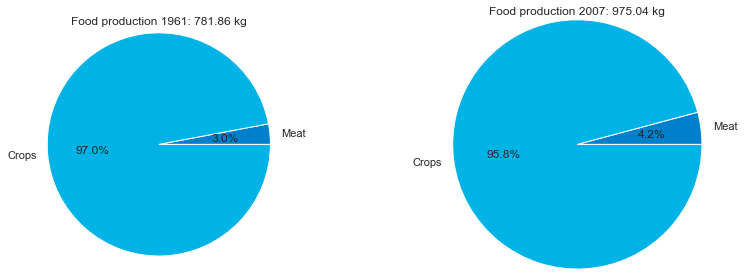

In [69]:
#Year on year growth of meat and crop production
#Average growth of meat production in total per year
mean_meat_prodgrow = (meat_total.groupby('Year').sum().diff() / meat_total.groupby('Year').sum()).Value.mean() * 100

#Average growth of crops production in total per year
mean_crop_prodgrow = (crops_total.groupby('Year').sum().diff() / crops_total.groupby('Year').sum()).Value.mean() * 100

#Average population growth globally per year
mean_pop_growth = (pop_cont.groupby('Year').sum().diff() / pop_cont.groupby('Year').sum()).Value.mean() * 100

#Total food production per person in 1961 and 2007
temp1 = (comparison_m['1961 total [tonnes]'].sum() + comparison_c['1961 total [tonnes]'].sum())\
        / population_start_year.Value.sum()  
temp2 = (comparison_m['2007 total [tonnes]'].sum() + comparison_c['2007 total [tonnes]'].sum())\
        / population_end_year.Value.sum()
change = temp2 / temp1 * 100 - 100    

temp_labels = ['Meat', 'Crops']
sizes1961 = [(comparison_m['1961 total [tonnes]'].sum() / population_start_year.Value.sum())/temp1,
         (comparison_c['1961 total [tonnes]'].sum() / population_start_year.Value.sum())/temp1]
sizes2007 = [(comparison_m['2007 total [tonnes]'].sum() / population_end_year.Value.sum())/temp1,
         (comparison_c['2007 total [tonnes]'].sum() / population_end_year.Value.sum())/temp1]

fig, ax = plt.subplots(1, 2)

fig.set_size_inches(10,10)
fig.subplots_adjust(wspace = 2, hspace = 5)
pie_rad = 2
area = np.pi * (pie_rad**2)

title1 = 'Food production 1961: ' + str(round(temp1, 2)) + ' kg'
title2 = 'Food production 2007: ' + str(round(temp2, 2)) + ' kg'

ax[0].pie(sizes1961, labels = temp_labels, radius = pie_rad, 
          autopct='%1.1f%%', colors = [[0, 0.5, 0.8], [0, 0.7, 0.9]])
ax[0].set_title(title1, pad = 50)
ax[1].pie(sizes2007, labels = temp_labels, radius = np.sqrt(area*(1+change/100)/np.pi), 
          autopct='%1.1f%%', colors = [[0, 0.5, 0.8], [0, 0.7, 0.9]])
ax[1].set_title(title2, pad = 60)

print('Increase of food production per person: ', round(change, 2), '%')

Globally the food production per person has increased by nearly 25%. At the same time the proportion of meat to crops has change as well, as can be seen in the plot above. In other words, today we produce both more food per person and our diets have become more meat heavy. The increase is very logical as the world has become richer (GDP per capita has steadily increased https://data.worldbank.org/indicator/NY.GDP.PCAP.KD), we produce more food and less people are starving. 

In [70]:
comparison_m.sort_values(by = 'Area', inplace = True)
comparison_c.sort_values(by = 'Area', inplace = True)

pop_cont_start = population_start_year.drop('Area Code', axis = 1).sort_values(by = 'Area').reset_index()
pop_cont_end = population_end_year.drop('Area Code', axis = 1).sort_values(by = 'Area').reset_index()

product_pers = pd.DataFrame({'Area':comparison_m.Area,
                             'Meat per person 1961 (kg)' : comparison_m['1961 total [tonnes]'].values / pop_cont_start.Value,
                             'Meat per person 2007 (kg)' : comparison_m['2007 total [tonnes]'].values / pop_cont_end.Value,
                             'Crops per person 1961 (kg)' : comparison_c['1961 total [tonnes]'].values / pop_cont_start.Value,
                             'Crops per person 2007 (kg)' : comparison_c['2007 total [tonnes]'].values / pop_cont_end.Value})
product_pers['% Increase meat'] = round(product_pers['Meat per person 2007 (kg)']
                                        / product_pers['Meat per person 1961 (kg)'] * 100 - 100,2)
product_pers['% Increase crops'] = round(product_pers['Crops per person 2007 (kg)']
                                         / product_pers['Crops per person 1961 (kg)'] * 100 - 100,2)

product_pers

,Area,Meat per person 1961 (kg),Meat per person 2007 (kg),Crops per person 1961 (kg),Crops per person 2007 (kg),% Increase meat,% Increase crops
0,World,13.474699,15.263559,637.920628,629.614385,13.28,-1.30
1,Africa,5.308351,26.642202,451.125715,710.862655,401.89,57.58
2,Asia,46.395296,73.587627,1215.135412,1301.835252,58.61,7.13
3,Europe,86.547058,138.026550,1952.933606,3143.525706,59.48,60.96
4,Northern America,140.544138,174.310982,1102.921385,1449.491258,24.03,31.42
5,Oceania,42.669172,92.514345,825.775312,1407.529798,116.82,70.45
6,South America,23.117298,40.575336,758.741570,934.460200,75.52,23.16


In the table above we can see that all continents have seen an increase in production of meat per person, with Asia experiencing the largest increase and Africa the smallest. Europe and Northern America have seen a similar increase, however it is worth noting that the procuction of meat was higher to begin with in Northern America. There are 2 distinct groups in meat production quantities, Asia & Africa and the rest. In growth however Asia is in a league of its own. Overall production is clearly highest per capita in Oceania.

When looking at at the crops production we can see that groups are again quite distinct with Africa and Asia producing the least and while the rest produce much more food per person. Interestingly the production of crops per capita has in fact decreased in Africa while all other continents have experienced growth. 

In [71]:
#Correlation between yearly lgarithmic increase in global meat and crop production 
pd.DataFrame({'Meat':np.log(meat_cont[meat_cont['Item'] == 'Meat, Total'].groupby('Year').sum().Value).diff().dropna(),
               'Crops':np.log(crops_cont[crops_cont['Item'] == 'Crops, total'].groupby('Year').sum().Value).diff().dropna()}).corr()

,Meat,Crops
Meat,1.000000,-0.324508
Crops,-0.324508,1.000000


When looking at the correlation between the growth of crop and meat production, we can see that they are negatively correlated. In other words, we can see that when meat production increases crops production decreases globally. However, the correlation is not very strong at -0.32, and correlation does not equal causation, and thus increases in meat production do not necessarily cause a decrease in crop production.

In [72]:
tmp = meat_no_total.groupby(['Year', 'Item']).agg({'Value':'sum'}).reset_index().sort_values(by=['Year', 'Item'], ascending=True)
meat_world = pd.DataFrame(columns=meat_no_total.Item.sort_values().unique(), 
             index=tmp.Year.unique(),
             data=tmp.Value.values.reshape(len(tmp.Year.unique()),len(meat_no_total.Item.unique())))

tmp = meat_cont[meat_cont['Item'] == 'Meat, Total'][{'Area', 'Year', 'Value'}].sort_values(by='Year')
meat_continentally = pd.DataFrame(columns=meat_cont.Area.sort_values().unique(), 
                                  index=tmp.Year.unique(),
                                  data=tmp.Value.values.reshape(len(tmp.Year.unique()), len(meat_cont.Area.unique())))

tmp = crops_cont[crops_cont['Item'] == 'Crops, total'][{'Area', 'Year', 'Value'}].sort_values(by='Year')
crops_continentally = pd.DataFrame(columns=crops_cont.Area.sort_values().unique(), 
                                  index=tmp.Year.unique(),
                                  data=tmp.Value.values.reshape(len(tmp.Year.unique()), len(crops_cont.Area.unique())))

cont_correlation = pd.DataFrame(columns = ['Correlation'], index=meat_cont.Area.unique(), data=[0]*6)
for continent in meat_cont.Area.unique():
    cont_correlation.loc[continent] = (pd.DataFrame({'Meat':np.log(meat_continentally[continent]).diff().dropna(),
                                                    'Crops':np.log(crops_continentally[continent]).diff().dropna()}).corr().iloc[0,1])
cont_correlation

,Correlation
Africa,0.917087
Asia,0.858598
Europe,0.914018
Northern America,0.870079
Oceania,0.881410
South America,0.880336


When looking at the correlation of crop and meat production growth continentally, we can see that compared to global change, the changes are much less correlated, except for Northern America. In other words, within continents there does not seem to be a link between meat and crop production.

<a id=Q3></a>
## Question 3 - How are the differences in production quantities between the different continents?

The purpose of this question is to study the difference in production at a continent-level. For example, it can be interesting to see the difference between developed continents, like Europe and North-America, and continents like Africa and Asia.

- Study food production in general, and with a crops vs. meat analysis.
- What can be said about the normalized production?
- Can we say if any continents are producing more than it needs?
- Try to find data on how much food a person needs per year.
    - This is pretty hard because of energy/tonne

In [73]:
from scripts.helpers import merge_crops_and_meats, center_around_average, center_around_average
from scripts.helpers import percentage_growth, normalize_on_population

print('Normalize function', normalize_on_population.__doc__)
print('Merge function:', merge_crops_and_meats.__doc__)
print('Average function:', center_around_average.__doc__)
print('Growth function:', percentage_growth.__doc__)

meat_norm = normalize_on_population(meat_cont, pop_cont)
crops_norm = normalize_on_population(crops_cont, pop_cont)

# Small namechange to fit to rest of code
crops_norm.loc[crops_norm['Item'] == 'Crops, total', ['Item']] = 'Crops, Total'

Normalize function 
    Adds an extra column to dataframe 'Norm Value' which is value of df1 divided by population in that area
    
Merge function: 
    Merges crops and meat and adds a extra column Total Production = Crops + Meats
    Keeps only Meats, Total and Crops, Total
    
Average function: 
    Substracts the mean of each column in params from the same column
    
Growth function: 
    Calulates how much of each row contribues to total growth
    


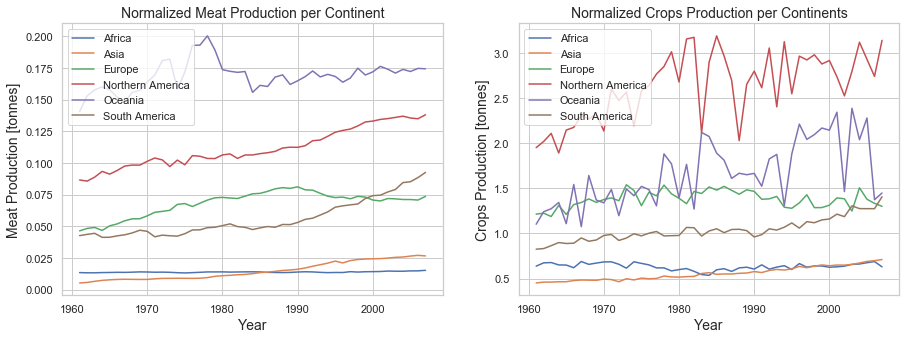

In [74]:
fig = plt.figure(figsize = (15, 11))

ax1 = plt.subplot(2,2,1)
plot_compare_areas(meat_norm[meat_norm['Item'] == 'Meat, Total'], 
                   y = 'Norm Value', y_label = 'Meat Production [tonnes]',
                   title='Normalized Meat Production per Continent',
                   subplot = True, ax = ax1)

ax2 = plt.subplot(2,2,2)
plot_compare_areas(crops_norm[crops_norm['Item'] == 'Crops, Total'], 
                    y = 'Norm Value', y_label = 'Crops Production [tonnes]',
                    title='Normalized Crops Production per Continents',
                    subplot = True, ax = ax2)


This shows some interesting trends. First of all we see the assumably porest continents produces the least of food per person. We will try to make these differences more clear.

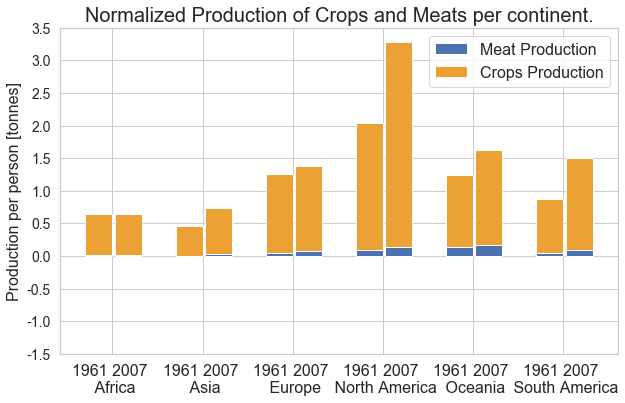

In [75]:
# Create a new dataframe with both crops and meat
food_total = merge_crops_and_meats(meat_norm, crops_norm)
food_1961 = food_total[food_total['Year'] == 1961].sort_values(by=['Area']).reset_index(drop=True)
food_2007 = food_total[food_total['Year'] == 2007].sort_values(by=['Area']).reset_index(drop=True)


bar_plot(food_1961, food_2007, 'Normalized Production of Crops and Meats per continent.')


This is how the world looked in 1961 and in 2007 for each continent normalized on population. We see that the North America is producing a lot more grain than the rest of the continents.

Average Total production in 1961: 1.09 tonnes per person
Average Total production in 2007: 1.53 tonnes per person


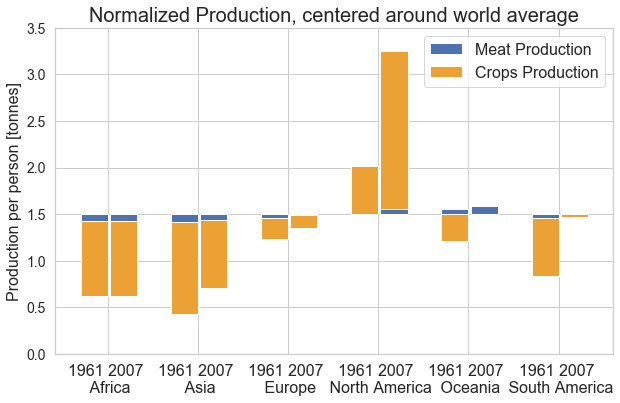

In [76]:
from scripts.visualization import bar_plot, bar_plot_with_population

# Average each column around world average
food_1961_avg, food_1961_means = center_around_average(food_1961, ['Norm Meat', 'Norm Crops', 'Norm Total Production'])
food_1961_avg = food_1961_avg.sort_values(by=['Area']).reset_index(drop=True)
food_2007_avg, food_2007_means = center_around_average(food_2007, ['Norm Meat', 'Norm Crops', 'Norm Total Production'])
food_2007_avg = food_2007_avg.sort_values(by=['Area']).reset_index(drop=True)

# Move the bars in 1961 to compansate for different average
food_1961_avg['Norm Total Production'] -= food_2007_means['Norm Total Production'] - food_1961_means['Norm Total Production']
food_1961_avg['Norm Meat'] -= food_2007_means['Norm Meat'] - food_1961_means['Norm Meat']
food_1961_avg['Norm Crops'] -= food_2007_means['Norm Crops'] - food_1961_means['Norm Crops']

bar_plot(food_1961_avg, food_2007_avg,
         'Normalized Production, centered around world average',
         center = food_2007_means['Norm Total Production'] )


print('Average Total production in 1961: {} tonnes per person'.format(np.around(food_1961_means['Norm Total Production'], decimals=2)))
print('Average Total production in 2007: {} tonnes per person'.format(np.around(food_2007_means['Norm Total Production'], decimals=2)))

This plot shows how distribution of meat and crops production in the different continents averaged around the world average. One very interesting thing we can see here is that the differences in the world has generally decreased, except from North America who clearly stand out. North America are the ones that by far produce the most, and has a significant increase in crops production.  
Notes:
- These plots only include production, and as we do not have trade data we do not know if North America actually eats more food or is exporting it.
- Europe has decreased in 2007 compared to 1961, and this is a continent with somewhat similar development in wealth and demographics as North America during the period. This might show that wealth is not as relevant as other factors as: 
    - Lands available for farming
    - Culture
    
    

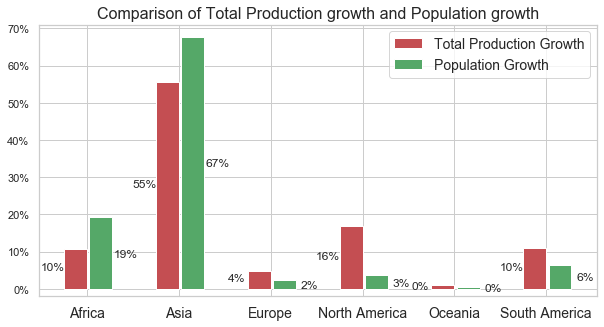

In [77]:
from scripts.visualization import bar_plot, bar_plot_with_population

food_growth = percentage_growth(food_2007, food_1961, ['Population', 'Meat', 'Crops', 'Total Production'])
bar_plot_with_population(food_growth, 'Comparison of Total Production growth and Population growth')

This plot shows how much each of the continents have contributed in both Total Production and in Population.  
For example: 67% of the worlds population growth has happend in Asia, whilst only 55% of the total production growth. North America on the other hand is responsible for 16% of the production increase, but had only 3% of the worlds population growth.  

From this we can say that even though higher population leads to more food production, it is not what determines how much food is produced. Only by speculating, factors like wealth and available technology might be more significant.

<a id=Q4></a>
## Question 4 - How has the development in agriculture affected emission of greenhouse gasses?

This question is about the consequences of what we have studied in the previous questions.

- Can we find evidence that higher meat consumption leads to higher emissions?
- Is it better for the environment to eat crops rather than livestock?
- Are there any particular meat or crop that affect the CO2 emissions more/less than the average?

****Preparing the data****

In order to study the agricultural production and the emissions we need the 3 datasets to match when it comes to time and categories. All three datasets will therefor by limited to a certain timeframe and the categories that are missing from the emission dataset will be removed from the crop and meat datasets.

In [78]:
# Load data from emissions dataset
emi_data = pd.read_pickle(data_path + 'continent_categorized_emissions.pkl')
# Restructure datasets
emission_data = emi_data.groupby(['Area','Year','Item']).agg({'Value':'sum', 'Element':'first', 'Unit':'first'}).reset_index()
# Make sure that years in emission dataset align with the rest of the datasets
emission_data = emission_data[(emission_data.Year >= starting_year) & (emission_data.Year <= ending_year)]

print(emission_data.Item.unique())
print(crops_cont.Item.unique())

['Cereals excluding rice' 'Meat, buffalo' 'Meat, cattle' 'Meat, chicken'
 'Meat, goat' 'Meat, pig' 'Meat, sheep' 'Rice, paddy']
['Oilcrops & oilcakes' 'Fruits excl melons' 'Vegetables & melons'
 'Roots & tubers' 'Cereals' 'Coarse grain' 'Other crops' 'Crops, total']


As for the crops dataset, the only category that we have emission data on is _Cereals excluding rice_ and _Rice, paddy_ which corresponds with _Cereals_ in the crops dataset, as is shown above. Therefore, all items apart from _Cereals_ are removed. 

In [79]:
# Keep only crop data that we have emission data on
crop_relevant = crops_cont[crops_cont.Item == 'Cereals']

print(emission_data.Item.unique())
print(meat_cont.Item.unique())

['Cereals excluding rice' 'Meat, buffalo' 'Meat, cattle' 'Meat, chicken'
 'Meat, goat' 'Meat, pig' 'Meat, sheep' 'Rice, paddy']
['Meat, equidae & camelidae' 'Meat, bovidae' 'Meat, bird excl chicken'
 'Meat, other' 'Meat, Total' 'Meat, cattle' 'Meat, chicken' 'Meat, pig']


The same will be done with the meat dataset, all of the items that aren't present in the emission dataset will be removed.

In [80]:
# Keep only meat data that we have emission data on
meat_relevant = meat_cont[meat_cont.Item.isin(emission_data.Item.unique())]

****Studying the data****

In order to answer questions about developments in agriculture and it's impact on emissions it is of interest to look att how the productions and emissions has increased during the years 1961 to 2007.

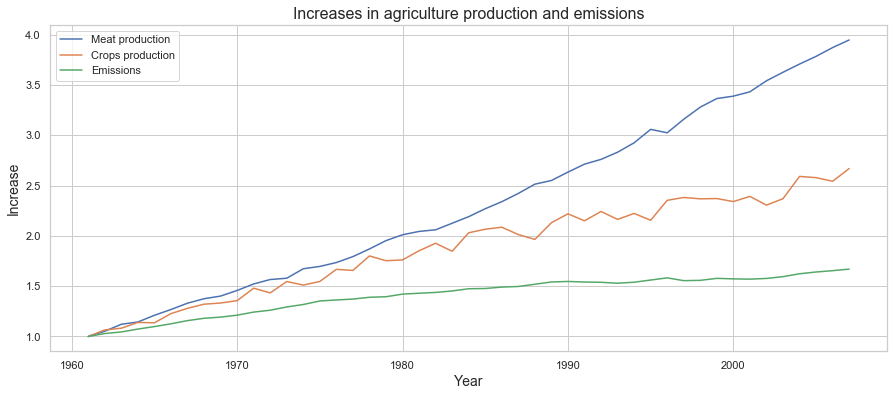

Meat production has increased 294% since 1961 
Crop production has increased 166% since 1961 
Emissions from agriculture have increased 66% since 1961


In [81]:
meat_yearly = meat_relevant.groupby('Year').agg({'Value':'sum'})
crop_yearly = crop_relevant.groupby('Year').agg({'Value':'sum'})
emission_yearly = emission_data.groupby('Year').agg({'Value':'sum'})

plt.figure(figsize = (15,6))
plt.plot(meat_yearly.Value / meat_yearly.Value.array[0])
plt.plot(crop_yearly.Value / crop_yearly.Value.array[0])
plt.plot(emission_yearly.Value / emission_yearly.Value.array[0])
plt.xlabel('Year', fontsize=14)
plt.ylabel('Increase', fontsize=14)
plt.title('Increases in agriculture production and emissions', fontsize=16)
plt.legend(['Meat production', 'Crops production', 'Emissions'])
plt.show()
print(\
'Meat production has increased {0}% since 1961 \n\
Crop production has increased {1}% since 1961 \n\
Emissions from agriculture have increased {2}% since 1961'.format(
                        int(meat_yearly.Value.array[-1] / meat_yearly.Value.array[0] * 100) - 100,
                        int(crop_yearly.Value.array[-1] / crop_yearly.Value.array[0] * 100) - 100,
                        int(emission_yearly.Value.array[-1] / emission_yearly.Value.array[0] * 100) - 100))

From the plot above we can see that the production of both meat and crops as well as the emissions have increased since 1961. It is also worth noting that emission hasn't seen the same growth and meat has grown quite a lot more than crops. Now, it seems weird that emissions hasn't seen the same increase as crop and meat combined, this might be due to higher efficency in both meat and crop production leading to less emissions per produced tonne of chosen agriculture product. Let's examine!

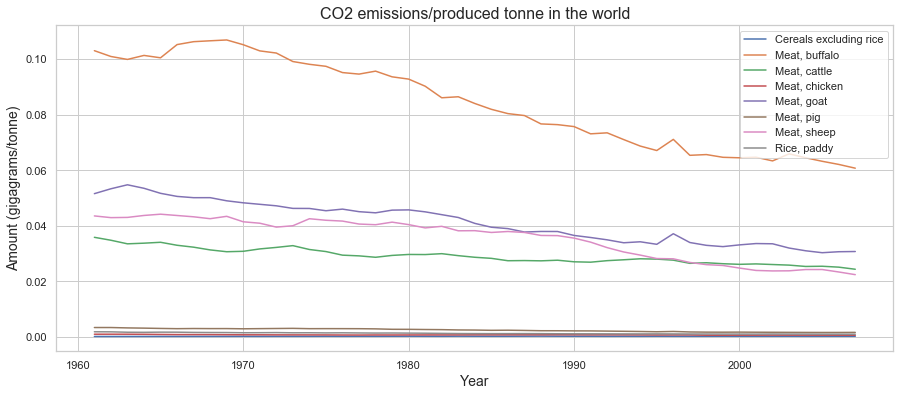

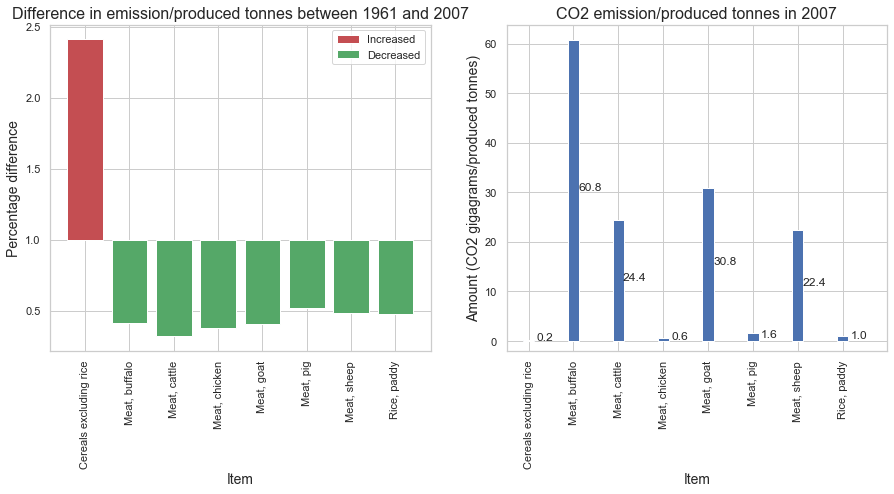

In [82]:
def autolabel_q4(rects, pop_growth, left = False):
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        if left:
            plt.text(rect.get_x() - rect.get_width()/2, height/2 - 0.01,
                    '{}'.format(round(pop_growth[idx], 1)),
                    ha='center', va='bottom', rotation=0)
        else:
            plt.text(rect.get_x() + rect.get_width()/2 + 0.37, height/2 - 0.01,
                    '{}'.format(round(pop_growth[idx], 1)),
                    ha='center', rotation=0)

world_categorized_emissions = emission_data.groupby(['Item', 'Year']).agg({'Value':'sum'}).reset_index()
world_categorized_production = pd.read_pickle(data_path + 'world_categorized_production.pkl')
world_categorized_production = world_categorized_production[world_categorized_production.Year <= 2007]

plt.figure(figsize = (15,6))

items = world_categorized_emissions.Item.unique()
efficency_diff = []
co2_tonnes = []

for item in items:
    years = world_categorized_emissions[world_categorized_emissions['Item'] == item].Year.values
    item_emissions = world_categorized_emissions[world_categorized_emissions['Item'] == item].Value.values
    item_production = world_categorized_production[world_categorized_production['Item'] == item].Value.values
    plt.plot(years, item_emissions/item_production)
    
    eff_1961 = item_emissions[0]/item_production[0]
    eff_2007 = item_emissions[-1]/item_production[-1]
    diff = eff_2007/eff_1961
    efficency_diff.append(diff if diff >= 1 else -diff)
    
    co2_tonnes.append(1000 * item_emissions[-1]/item_production[-1])
    
plt.legend(world_categorized_emissions.Item.unique())
plt.title('CO2 emissions/produced tonne in the world', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount (gigagrams/tonne)', fontsize=14)
plt.show()

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
ax = plt.bar(x=items, height=efficency_diff, bottom=1, color= ['r' if eff > 1 else 'g' for eff in efficency_diff])
plt.xticks(rotation = 90)
plt.title('Difference in emission/produced tonnes between 1961 and 2007', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Percentage difference', fontsize=14)
plt.legend((ax[0], ax[1]), ('Increased', 'Decreased'))

plt.subplot(1,2,2)
width = 0.25
margin = 0.0025
p1 = plt.bar(x=np.arange(len(items)), height=co2_tonnes, width=width)
plt.xticks(rotation = 90)
plt.title('CO2 emission/produced tonnes in 2007', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Amount (CO2 gigagrams/produced tonnes)', fontsize=14)
autolabel_q4(p1, co2_tonnes)
plt.xticks(np.arange(len(items)), items)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([-2,ymax])
plt.xlim([xmin,xmax+0.5])
plt.show()

As we assumed, most of the items are produced more efficently in 2007 as opposed to 1961 apart from _Cereals, excluding rice_. What is also interesting is the difference in CO2 emission per produced tonne for the various items. We can see that _Meat, buffalo_, _Meat, cattle_, _Meat, goat_ and _Meat, sheep_ produces a lot more CO2 during production compared to _Meat, chicken_, _Meat,  pig_, _Cereals, excluding rice_ and _Rice, paddy_.

In order to compare the emissions per tonnes of produced item it is necessary to take the energy in each food into consideration. For example, if cattle meat has 25 times the amount of energy in its food compared with rice we can not say that meat cattle is worse to produce than rice, even though the plot above indicates that. We could also discuss further and compare proteins/fats/carbohydrates in each item, however, we will only compare the energy in terms of calories for each item to try and get a better view of different food's impact on the greenhouse gasses.

Here we will have to make some assumptions. The energy data will be taken from the [USDA](https://fdc.nal.usda.gov/index.html) database. However, we could not find data on energy/tonnes of a whole animal but will instead look at _Beef, ground, 85% lean meat / 15% fat, patty, cooked, broiled_ when determining the energy level of _Meat, cattle_ and so on. 



In [83]:
# Data from USDA, Kcal per 100g
# Order is in the same way as items are in the plots above
kcalories = [378.0, 109.0, 250.5, 239.0, 143.2, 242.1, 294.0, 130.0] 
# Scale to: Kcal per tonnes
kcalories_tonnes = np.asarray(kcalories) * 10000

item_energy = pd.Series(kcalories_tonnes, items)
item_energy

Cereals excluding rice    3780000.0
Meat, buffalo             1090000.0
Meat, cattle              2505000.0
Meat, chicken             2390000.0
Meat, goat                1432000.0
Meat, pig                 2421000.0
Meat, sheep               2940000.0
Rice, paddy               1300000.0
dtype: float64

Now that we have the amount of energy per tonnes of item, let's scale the previous values in the _CO2 emission/produced tonnes in 2007_ plot with each items energy.

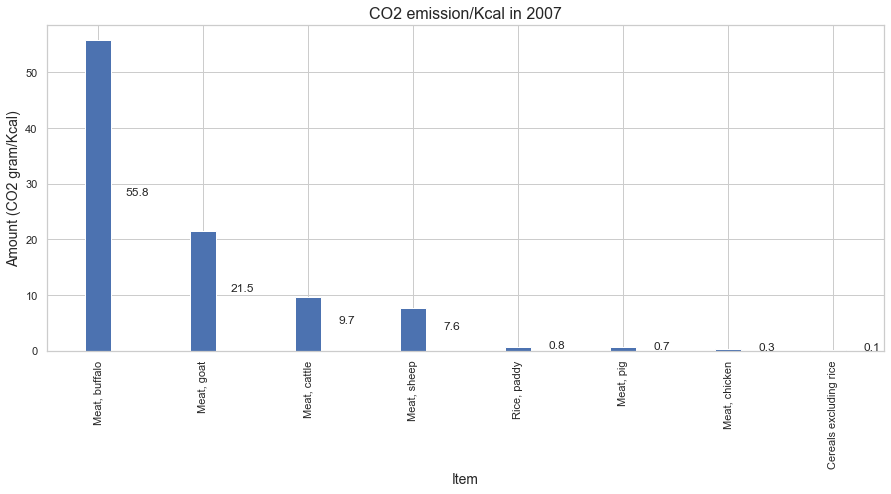

In [84]:
# Scale to: CO2 gram emitted per kcal
gram_emission_kcal = (co2_tonnes/kcalories_tonnes) * 1e6
item_kcal_emission = pd.Series(gram_emission_kcal, items).sort_values(ascending=False)

plt.figure(figsize = (15,6))
p1 = plt.bar(x=item_kcal_emission.index, height=item_kcal_emission, width=width)
autolabel_q4(p1, item_kcal_emission)
plt.xticks(rotation = 90)
plt.title('CO2 emission/Kcal in 2007', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Amount (CO2 gram/Kcal)', fontsize=14)
plt.show()

When observing the plot above it is very important to keep in mind that the Kcal/100g for all of the different animals are too high. This is becuase all of the bones/skin etc that will not be eaten have not been taken into consideration. This means that all of the meat item's _CO2 gram/Kcal_ should be a bit higher. This is not the case with _Rice, paddy_ and _Cereals, excluding rice_ since all of what is produced can be consumed.

Now, we can still see that most of the meats emit way more CO2 per Kcal than the crops. Especially _Meat, buffalo_ emits a lot of CO2 per Kcal compared to the other items. We can also see that _Meat, chicken_ and _Meat, pig_ seem to emit less that _Rice, paddy_. However, we can not draw any conclusions as to wheter _Rice, paddy_ is worse than the meats mentioned because of our calculations. But, we can say that if one were to eat meat, pig and chicken are way better alternatives than meat from sheep, cattle, goat or buffalo. 

****Conclusions question 4****

- Meat and crop production has increased which has led to higher emissions.
- Most of the meat and crop production has become more effective which has lowered the emission per produced tonnes.
- The meat categories buffalo, cattle, goat and pig emit much more than the crops studied in this question and it is therefore better for the environment to eat crops rather than eating meat from these categories.
- Meat from pig and chicken are much better to eat compared to sheep, cattle, goat and buffalo as they seem to emit close to what cereals and rice emit.

<a id=Summary></a>
## Summary

To  summarize,  food  production  has  increased  a lot since  1961,  mostly  due  to  a  growing  global  population,1 and  particularly  meat  production  has increased.More food is produced per person in 2007 compared to 1961 and the richer continents the  world  are  producing  a  lot  more  food  per person than what the less developed continents are. People’s diet in 2007 consists of more meat than what it did in 1961.  It is better to avoid the meat categories cattle and bovidae animals as these categories  emit  a  lot  more CO2 during  production than for example pig and chicken do. In 2007, pig was the most produced meat category and cereals was the most produced crop category. The production of food is more efficient in 2007 and this leads to lower CO2 emissions resulting from agriculture production.